In [1]:
import numpy as np
import keras.backend as K
from keras.layers import *
from keras.initializers import *
from keras.models import *

class NALU(Layer):
    def __init__(self, units, MW_initializer='glorot_uniform',
                 G_initializer='glorot_uniform', mode="NALU",
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(NALU, self).__init__(**kwargs)
        self.units = units
        self.mode = mode
        self.MW_initializer = initializers.get(MW_initializer)
        self.G_initializer = initializers.get(G_initializer)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.W_hat = self.add_weight(shape=(input_dim, self.units),
                                     initializer=self.MW_initializer,
                                     name='W_hat')
        self.M_hat = self.add_weight(shape=(input_dim, self.units),
                                     initializer=self.MW_initializer,
                                     name='M_hat')
        if self.mode == "NALU":
            self.G = self.add_weight(shape=(input_dim, self.units),
                                     initializer=self.G_initializer,
                                     name='G')
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs):
        W = K.tanh(self.W_hat) * K.sigmoid(self.M_hat)
        a = K.dot(inputs, W)
        if self.mode == "NAC":
            output = a
        elif self.mode == "NALU":
            m = K.exp(K.dot(K.log(K.abs(inputs) + 1e-7), W))
            g = K.sigmoid(K.dot(K.abs(inputs), self.G))
            output = g * a + (1 - g) * m
        else:
            raise ValueError("Valid modes: 'NAC', 'NALU'.")
        return output

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'mode' : self.mode,
            'MW_initializer': initializers.serialize(self.MW_initializer),
            'G_initializer':  initializers.serialize(self.G_initializer)
        }
        base_config = super(Dense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def nalu_model(mode=NALU):
    x = Input((100,))
    y = NALU(2, mode=mode, 
             MW_initializer=RandomNormal(stddev=1),
             G_initializer=Constant(10))(x)
    y = NALU(1, mode=mode, 
             MW_initializer=RandomNormal(stddev=1),
             G_initializer=Constant(10))(y)
    return Model(x, y)

def mlp_model():
    x = Input((100,))
    y = Dense(2, activation="relu")(x)
    y = Dense(1)(y)
    return Model(x, y)

def get_data(N, op):
    split = 45
    trX = np.random.normal(0, 0.5, (N, 100))
    a = trX[:, :split].sum(1)
    b = trX[:, split:].sum(1)
    print(a.min(), a.max(), b.min(), b.max())
    trY = op(a, b)[:, None]
    teX = np.random.normal(0, 2, (N, 100))
    a = teX[:, :split].sum(1)
    b = teX[:, split:].sum(1)
    print(a.min(), a.max(), b.min(), b.max())
    teY = op(a, b)[:, None]
    return (trX, trY), (teX, teY)

if __name__ == "__main__":
    m = nalu_model("NALU")
    m.compile("rmsprop", "mse", metrics=["mae"])
    (trX, trY), (teX, teY) = get_data(2 ** 16, lambda a, b: a - b)
    K.set_value(m.optimizer.lr, 1e-2)
    m.fit(trX, trY, validation_data=(teX, teY), batch_size=1024, epochs=200)
    K.set_value(m.optimizer.lr, 1e-3)
    m.fit(trX, trY, validation_data=(teX, teY), batch_size=1024, epochs=200)
    K.set_value(m.optimizer.lr, 1e-4)
    m.fit(trX, trY, validation_data=(teX, teY), batch_size=1024, epochs=200)

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


-14.397589919490677 13.658761172539625 -14.922509322622451 15.577685232960834
-53.84106692357703 54.8557868461962 -70.91371270903508 75.59582714677863
Train on 65536 samples, validate on 65536 samples
Epoch 1/200
65536/65536 [==============================] - 1s 9us/step - loss: 19.2740 - mean_absolute_error: 3.4884 - val_loss: 206.4016 - val_mean_absolute_error: 11.4778
Epoch 2/200
65536/65536 [==============================] - 0s 3us/step - loss: 7.8754 - mean_absolute_error: 2.2081 - val_loss: 62.1204 - val_mean_absolute_error: 6.2932
Epoch 3/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.0083 - mean_absolute_error: 1.1014 - val_loss: 12.1530 - val_mean_absolute_error: 2.7856
Epoch 4/200
65536/65536 [==============================] - 0s 3us/step - loss: 0.3511 - mean_absolute_error: 0.4557 - val_loss: 1.8278 - val_mean_absolute_error: 1.0796
Epoch 5/200
65536/65536 [==============================] - 0s 3us/step - loss: 0.0470 - mean_absolute_error: 0.1644 -

65536/65536 [==============================] - 0s 3us/step - loss: 2.8149e-04 - mean_absolute_error: 0.0132 - val_loss: 0.0045 - val_mean_absolute_error: 0.0534
Epoch 95/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.7425e-04 - mean_absolute_error: 0.0131 - val_loss: 0.0043 - val_mean_absolute_error: 0.0523
Epoch 96/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.7747e-04 - mean_absolute_error: 0.0132 - val_loss: 0.0041 - val_mean_absolute_error: 0.0514
Epoch 97/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.7521e-04 - mean_absolute_error: 0.0131 - val_loss: 0.0087 - val_mean_absolute_error: 0.0745
Epoch 98/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.7147e-04 - mean_absolute_error: 0.0129 - val_loss: 0.0065 - val_mean_absolute_error: 0.0643
Epoch 99/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.7157e-04 - mean_absolute_error: 0.0130 - val_loss: 0.0045 - v

Epoch 141/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.4756e-04 - mean_absolute_error: 0.0125 - val_loss: 0.0041 - val_mean_absolute_error: 0.0512
Epoch 142/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.4581e-04 - mean_absolute_error: 0.0124 - val_loss: 0.0024 - val_mean_absolute_error: 0.0390
Epoch 143/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.3651e-04 - mean_absolute_error: 0.0121 - val_loss: 0.0039 - val_mean_absolute_error: 0.0498
Epoch 144/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.4001e-04 - mean_absolute_error: 0.0123 - val_loss: 0.0036 - val_mean_absolute_error: 0.0477
Epoch 145/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.4195e-04 - mean_absolute_error: 0.0123 - val_loss: 0.0049 - val_mean_absolute_error: 0.0556
Epoch 146/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.4534e-04 - mean_absolute_error: 0.0123 - v

Epoch 188/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.1669e-04 - mean_absolute_error: 0.0117 - val_loss: 0.0025 - val_mean_absolute_error: 0.0398
Epoch 189/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.1348e-04 - mean_absolute_error: 0.0116 - val_loss: 0.0032 - val_mean_absolute_error: 0.0451
Epoch 190/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.1543e-04 - mean_absolute_error: 0.0115 - val_loss: 0.0048 - val_mean_absolute_error: 0.0554
Epoch 191/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.1021e-04 - mean_absolute_error: 0.0115 - val_loss: 0.0048 - val_mean_absolute_error: 0.0552
Epoch 192/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.1710e-04 - mean_absolute_error: 0.0117 - val_loss: 0.0025 - val_mean_absolute_error: 0.0401
Epoch 193/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.1019e-04 - mean_absolute_error: 0.0114 - v

65536/65536 [==============================] - 0s 3us/step - loss: 2.0920e-06 - mean_absolute_error: 0.0011 - val_loss: 2.9672e-05 - val_mean_absolute_error: 0.0043
Epoch 35/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.1468e-06 - mean_absolute_error: 0.0011 - val_loss: 1.9597e-05 - val_mean_absolute_error: 0.0035
Epoch 36/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.1292e-06 - mean_absolute_error: 0.0011 - val_loss: 4.5845e-05 - val_mean_absolute_error: 0.0054
Epoch 37/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.0645e-06 - mean_absolute_error: 0.0011 - val_loss: 6.1182e-05 - val_mean_absolute_error: 0.0062
Epoch 38/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.1340e-06 - mean_absolute_error: 0.0012 - val_loss: 3.0487e-05 - val_mean_absolute_error: 0.0044
Epoch 39/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.1625e-06 - mean_absolute_error: 0.0012 - 

Epoch 126/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.1178e-06 - mean_absolute_error: 0.0011 - val_loss: 4.0316e-05 - val_mean_absolute_error: 0.0051
Epoch 127/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.0692e-06 - mean_absolute_error: 0.0011 - val_loss: 4.8446e-05 - val_mean_absolute_error: 0.0056
Epoch 128/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.1201e-06 - mean_absolute_error: 0.0011 - val_loss: 3.9315e-05 - val_mean_absolute_error: 0.0050
Epoch 129/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.1080e-06 - mean_absolute_error: 0.0011 - val_loss: 1.6082e-05 - val_mean_absolute_error: 0.0032
Epoch 130/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.0751e-06 - mean_absolute_error: 0.0011 - val_loss: 1.9861e-05 - val_mean_absolute_error: 0.0036
Epoch 131/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.1289e-06 - mean_absolu

Epoch 172/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.0986e-06 - mean_absolute_error: 0.0011 - val_loss: 2.3663e-05 - val_mean_absolute_error: 0.0039
Epoch 173/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.0646e-06 - mean_absolute_error: 0.0011 - val_loss: 6.4844e-05 - val_mean_absolute_error: 0.0064
Epoch 174/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.1452e-06 - mean_absolute_error: 0.0012 - val_loss: 2.0525e-05 - val_mean_absolute_error: 0.0036
Epoch 175/200
65536/65536 [==============================] - ETA: 0s - loss: 2.0457e-06 - mean_absolute_error: 0.0011   - 0s 3us/step - loss: 2.0962e-06 - mean_absolute_error: 0.0011 - val_loss: 4.8942e-05 - val_mean_absolute_error: 0.0056
Epoch 176/200
65536/65536 [==============================] - 0s 3us/step - loss: 2.0255e-06 - mean_absolute_error: 0.0011 - val_loss: 3.3750e-05 - val_mean_absolute_error: 0.0046
Epoch 177/200
65536/65536 [=================

65536/65536 [==============================] - 0s 3us/step - loss: 5.3330e-08 - mean_absolute_error: 1.1408e-04 - val_loss: 1.3600e-07 - val_mean_absolute_error: 2.9090e-04
Epoch 61/200
65536/65536 [==============================] - 0s 3us/step - loss: 5.3740e-08 - mean_absolute_error: 1.1667e-04 - val_loss: 3.8255e-07 - val_mean_absolute_error: 4.9267e-04
Epoch 62/200
65536/65536 [==============================] - 0s 3us/step - loss: 5.4095e-08 - mean_absolute_error: 1.1823e-04 - val_loss: 3.2164e-07 - val_mean_absolute_error: 4.5066e-04
Epoch 63/200
65536/65536 [==============================] - 0s 3us/step - loss: 5.3483e-08 - mean_absolute_error: 1.1578e-04 - val_loss: 2.1898e-07 - val_mean_absolute_error: 3.7128e-04
Epoch 64/200
65536/65536 [==============================] - 0s 3us/step - loss: 5.3621e-08 - mean_absolute_error: 1.1728e-04 - val_loss: 2.1277e-07 - val_mean_absolute_error: 3.6574e-04
Epoch 65/200
65536/65536 [==============================] - 0s 3us/step - loss: 5.4

Epoch 148/200
65536/65536 [==============================] - 0s 3us/step - loss: 5.2810e-08 - mean_absolute_error: 1.1704e-04 - val_loss: 3.1285e-07 - val_mean_absolute_error: 4.4417e-04
Epoch 149/200
65536/65536 [==============================] - 0s 3us/step - loss: 5.2116e-08 - mean_absolute_error: 1.1605e-04 - val_loss: 3.8172e-07 - val_mean_absolute_error: 4.9087e-04
Epoch 150/200
65536/65536 [==============================] - 0s 3us/step - loss: 5.2206e-08 - mean_absolute_error: 1.1701e-04 - val_loss: 4.1210e-07 - val_mean_absolute_error: 5.1090e-04
Epoch 151/200
65536/65536 [==============================] - 0s 3us/step - loss: 5.2454e-08 - mean_absolute_error: 1.1670e-04 - val_loss: 2.3115e-07 - val_mean_absolute_error: 3.8154e-04
Epoch 152/200
65536/65536 [==============================] - 0s 3us/step - loss: 5.2785e-08 - mean_absolute_error: 1.1671e-04 - val_loss: 3.3402e-07 - val_mean_absolute_error: 4.6004e-04
Epoch 153/200
65536/65536 [==============================] - 0s 3

Epoch 192/200
65536/65536 [==============================] - 0s 3us/step - loss: 5.1989e-08 - mean_absolute_error: 1.1422e-04 - val_loss: 2.3259e-07 - val_mean_absolute_error: 3.8305e-04
Epoch 193/200
65536/65536 [==============================] - 0s 3us/step - loss: 5.2461e-08 - mean_absolute_error: 1.1713e-04 - val_loss: 1.7282e-07 - val_mean_absolute_error: 3.2949e-04
Epoch 194/200
65536/65536 [==============================] - 0s 3us/step - loss: 5.1418e-08 - mean_absolute_error: 1.1533e-04 - val_loss: 4.5428e-07 - val_mean_absolute_error: 5.3615e-04
Epoch 195/200
65536/65536 [==============================] - 0s 3us/step - loss: 5.2572e-08 - mean_absolute_error: 1.1802e-04 - val_loss: 1.9958e-07 - val_mean_absolute_error: 3.5405e-04
Epoch 196/200
65536/65536 [==============================] - 0s 3us/step - loss: 5.2421e-08 - mean_absolute_error: 1.1701e-04 - val_loss: 2.3682e-07 - val_mean_absolute_error: 3.8652e-04
Epoch 197/200
65536/65536 [==============================] - 0s 3

In [9]:
import tensorflow as tf 
import matplotlib.pyplot as plt
# NAC
shape=[2,2]

In [14]:
W_hat = tf.Variable(tf.truncated_normal(shape, stddev=0.02)) 
M_hat = tf.Variable(tf.truncated_normal(shape, stddev=0.02))

In [15]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(W_hat))
    print(sess.run(M_hat))

[[ 0.02126696 -0.01736494]
 [ 0.0218068  -0.01778269]]
[[-0.00314439  0.00519143]
 [-0.00786404 -0.02085129]]


In [28]:
W = tf.tanh(W_hat) * tf.sigmoid(M_hat)

In [30]:
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(tf.tanh(W_hat)))
    print(sess.run(tf.tanh(M_hat)))
    print(sess.run(W))

[[ 0.02101293 -0.0052744 ]
 [ 0.00208387 -0.00801341]]
[[-0.01579947  0.01871609]
 [-0.01040051  0.01608262]]
[[ 0.01042346 -0.00266188]
 [ 0.00103652 -0.00403893]]


In [24]:
# Forward propogation
in_dim=4
a = tf.matmul(in_dim, W) 

In [31]:
def NAC(in_dim, out_dim):
    in_features = in_dim.shape[1]
    # define W_hat and M_hat
    W_hat = tf.get_variable(name = 'W_hat', initializer=tf.initializers.random_uniform(minval=-2, maxval=2),shape=[in_features, out_dim],  trainable=True)
    M_hat = tf.get_variable(name = 'M_hat', initializer=tf.initializers.random_uniform(minval=-2, maxval=2), shape=[in_features, out_dim], trainable=True)
    W = tf.nn.tanh(W_hat) * tf.nn.sigmoid(M_hat)
    a = tf.matmul(in_dim, W)
    return a, W 

In [15]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [18]:
img = cv2.imread("F:/pic1.png")
cv2.imshow("img",img)

In [6]:
def NAC(in_dim, out_dim):
    in_features = in_dim.shape[1]
    # define W_hat and M_hat
    W_hat = tf.get_variable(name = 'W_hat', initializer=tf.initializers.random_uniform(minval=-2, maxval=2),shape=[in_features, out_dim],  trainable=True)
    M_hat = tf.get_variable(name = 'M_hat', initializer=tf.initializers.random_uniform(minval=-2, maxval=2), shape=[in_features, out_dim], trainable=True)
    W = tf.nn.tanh(W_hat) * tf.nn.sigmoid(M_hat)
    a = tf.matmul(in_dim, W)
    return a, W 

In [4]:
# Generate a series of input number X1 and X2 for training
x1 = np.arange(0,10000,5, dtype=np.float32)
x2 = np.arange(5,10005,5, dtype=np.float32)
y_train = x1 + x2
x_train = np.column_stack((x1,x2))
print(x_train.shape)
print(y_train.shape)
# Generate a series of input number X1 and X2 for testing
x1 = np.arange(1000,2000,8, dtype=np.float32)
x2 = np.arange(1000,1500,4, dtype= np.float32)
x_test = np.column_stack((x1,x2))
y_test = x1 + x2
print()
print(x_test.shape)
print(y_test.shape)

(2000, 2)
(2000,)

(125, 2)
(125,)


Pre training MSE:  11078951.0

epoch: 0, MSE: 179591280.0
epoch: 1, MSE: 174260064.0
epoch: 2, MSE: 168938080.0
epoch: 3, MSE: 163636144.0
epoch: 4, MSE: 158364352.0
epoch: 5, MSE: 153132080.0
epoch: 6, MSE: 147948240.0
epoch: 7, MSE: 142820912.0
epoch: 8, MSE: 137757856.0
epoch: 9, MSE: 132766456.0
epoch: 10, MSE: 127853624.0
epoch: 11, MSE: 123026064.0
epoch: 12, MSE: 118290360.0
epoch: 13, MSE: 113652872.0
epoch: 14, MSE: 109119944.0
epoch: 15, MSE: 104697624.0
epoch: 16, MSE: 100392080.0
epoch: 17, MSE: 96209192.0
epoch: 18, MSE: 92154680.0
epoch: 19, MSE: 88233936.0
epoch: 20, MSE: 84452096.0
epoch: 21, MSE: 80813720.0
epoch: 22, MSE: 77322832.0
epoch: 23, MSE: 73982672.0
epoch: 24, MSE: 70795728.0
epoch: 25, MSE: 67763448.0
epoch: 26, MSE: 64886268.0
epoch: 27, MSE: 62163548.0
epoch: 28, MSE: 59593372.0
epoch: 29, MSE: 57172828.0
epoch: 30, MSE: 54897812.0
epoch: 31, MSE: 52763196.0
epoch: 32, MSE: 50763048.0
epoch: 33, MSE: 48890564.0
epoch: 34, MSE: 47138512.0
epoch: 35, MSE: 4

epoch: 569, MSE: 187367.703125
epoch: 570, MSE: 186832.21875
epoch: 571, MSE: 186299.25
epoch: 572, MSE: 185767.96875
epoch: 573, MSE: 185240.703125
epoch: 574, MSE: 184713.828125
epoch: 575, MSE: 184191.328125
epoch: 576, MSE: 183670.6875
epoch: 577, MSE: 183150.8125
epoch: 578, MSE: 182634.671875
epoch: 579, MSE: 182120.953125
epoch: 580, MSE: 181608.5625
epoch: 581, MSE: 181099.78125
epoch: 582, MSE: 180592.3125
epoch: 583, MSE: 180087.640625
epoch: 584, MSE: 179584.828125
epoch: 585, MSE: 179085.625
epoch: 586, MSE: 178586.828125
epoch: 587, MSE: 178090.171875
epoch: 588, MSE: 177597.6875
epoch: 589, MSE: 177105.875
epoch: 590, MSE: 176616.1875
epoch: 591, MSE: 176129.515625
epoch: 592, MSE: 175644.40625
epoch: 593, MSE: 175161.9375
epoch: 594, MSE: 174681.265625
epoch: 595, MSE: 174201.859375
epoch: 596, MSE: 173727.15625
epoch: 597, MSE: 173252.140625
epoch: 598, MSE: 172779.875
epoch: 599, MSE: 172309.0625
epoch: 600, MSE: 171840.921875
epoch: 601, MSE: 171374.84375
epoch: 602, 

epoch: 914, MSE: 85960.2578125
epoch: 915, MSE: 85803.1171875
epoch: 916, MSE: 85647.359375
epoch: 917, MSE: 85491.171875
epoch: 918, MSE: 85335.453125
epoch: 919, MSE: 85180.9609375
epoch: 920, MSE: 85026.3515625
epoch: 921, MSE: 84871.71875
epoch: 922, MSE: 84718.421875
epoch: 923, MSE: 84565.265625
epoch: 924, MSE: 84412.65625
epoch: 925, MSE: 84259.921875
epoch: 926, MSE: 84108.3828125
epoch: 927, MSE: 83956.765625
epoch: 928, MSE: 83805.8828125
epoch: 929, MSE: 83654.7578125
epoch: 930, MSE: 83503.9375
epoch: 931, MSE: 83354.2578125
epoch: 932, MSE: 83205.5234375
epoch: 933, MSE: 83056.515625
epoch: 934, MSE: 82908.03125
epoch: 935, MSE: 82759.2890625
epoch: 936, MSE: 82611.84375
epoch: 937, MSE: 82464.9453125
epoch: 938, MSE: 82317.171875
epoch: 939, MSE: 82170.3515625
epoch: 940, MSE: 82024.03125
epoch: 941, MSE: 81878.6484375
epoch: 942, MSE: 81733.59375
epoch: 943, MSE: 81588.640625
epoch: 944, MSE: 81443.6328125
epoch: 945, MSE: 81299.5703125
epoch: 946, MSE: 81154.7890625
ep

epoch: 1209, MSE: 53526.55078125
epoch: 1210, MSE: 53449.65625
epoch: 1211, MSE: 53374.1328125
epoch: 1212, MSE: 53298.47265625
epoch: 1213, MSE: 53222.875
epoch: 1214, MSE: 53146.86328125
epoch: 1215, MSE: 53071.9921875
epoch: 1216, MSE: 52996.24609375
epoch: 1217, MSE: 52921.5078125
epoch: 1218, MSE: 52846.6171875
epoch: 1219, MSE: 52771.51171875
epoch: 1220, MSE: 52697.23046875
epoch: 1221, MSE: 52622.83984375
epoch: 1222, MSE: 52548.3671875
epoch: 1223, MSE: 52473.76171875
epoch: 1224, MSE: 52400.16796875
epoch: 1225, MSE: 52326.78515625
epoch: 1226, MSE: 52252.6640625
epoch: 1227, MSE: 52179.375
epoch: 1228, MSE: 52106.16015625
epoch: 1229, MSE: 52033.13671875
epoch: 1230, MSE: 51959.9921875
epoch: 1231, MSE: 51887.23828125
epoch: 1232, MSE: 51814.20703125
epoch: 1233, MSE: 51742.171875
epoch: 1234, MSE: 51668.9453125
epoch: 1235, MSE: 51597.47265625
epoch: 1236, MSE: 51524.8125
epoch: 1237, MSE: 51452.81640625
epoch: 1238, MSE: 51380.8671875
epoch: 1239, MSE: 51308.9921875
epoch:

epoch: 1512, MSE: 36169.4765625
epoch: 1513, MSE: 36126.3046875
epoch: 1514, MSE: 36084.06640625
epoch: 1515, MSE: 36041.07421875
epoch: 1516, MSE: 35999.01171875
epoch: 1517, MSE: 35956.44921875
epoch: 1518, MSE: 35914.1875
epoch: 1519, MSE: 35871.55078125
epoch: 1520, MSE: 35829.59375
epoch: 1521, MSE: 35787.52734375
epoch: 1522, MSE: 35745.75390625
epoch: 1523, MSE: 35703.4765625
epoch: 1524, MSE: 35661.7421875
epoch: 1525, MSE: 35620.0390625
epoch: 1526, MSE: 35578.08984375
epoch: 1527, MSE: 35536.56640625
epoch: 1528, MSE: 35494.94140625
epoch: 1529, MSE: 35452.81640625
epoch: 1530, MSE: 35411.7421875
epoch: 1531, MSE: 35370.05078125
epoch: 1532, MSE: 35329.296875
epoch: 1533, MSE: 35288.04296875
epoch: 1534, MSE: 35246.6875
epoch: 1535, MSE: 35205.34765625
epoch: 1536, MSE: 35164.82421875
epoch: 1537, MSE: 35123.2734375
epoch: 1538, MSE: 35082.65625
epoch: 1539, MSE: 35041.9453125
epoch: 1540, MSE: 35001.24609375
epoch: 1541, MSE: 34960.17578125
epoch: 1542, MSE: 34919.2734375
ep

epoch: 1860, MSE: 24786.572265625
epoch: 1861, MSE: 24761.65625
epoch: 1862, MSE: 24736.5390625
epoch: 1863, MSE: 24711.759765625
epoch: 1864, MSE: 24687.529296875
epoch: 1865, MSE: 24662.345703125
epoch: 1866, MSE: 24637.8125
epoch: 1867, MSE: 24613.501953125
epoch: 1868, MSE: 24588.251953125
epoch: 1869, MSE: 24564.19140625
epoch: 1870, MSE: 24539.71484375
epoch: 1871, MSE: 24515.03125
epoch: 1872, MSE: 24490.470703125
epoch: 1873, MSE: 24466.0234375
epoch: 1874, MSE: 24441.81640625
epoch: 1875, MSE: 24417.07421875
epoch: 1876, MSE: 24392.677734375
epoch: 1877, MSE: 24368.4921875
epoch: 1878, MSE: 24344.431640625
epoch: 1879, MSE: 24320.494140625
epoch: 1880, MSE: 24296.021484375
epoch: 1881, MSE: 24271.67578125
epoch: 1882, MSE: 24247.455078125
epoch: 1883, MSE: 24223.892578125
epoch: 1884, MSE: 24199.259765625
epoch: 1885, MSE: 24175.28125
epoch: 1886, MSE: 24151.619140625
epoch: 1887, MSE: 24127.693359375
epoch: 1888, MSE: 24103.216796875
epoch: 1889, MSE: 24079.39453125
epoch: 18

epoch: 2155, MSE: 18733.84765625
epoch: 2156, MSE: 18716.607421875
epoch: 2157, MSE: 18699.759765625
epoch: 2158, MSE: 18682.921875
epoch: 2159, MSE: 18665.8984375
epoch: 2160, MSE: 18649.4453125
epoch: 2161, MSE: 18632.720703125
epoch: 2162, MSE: 18615.90625
epoch: 2163, MSE: 18599.10546875
epoch: 2164, MSE: 18582.6796875
epoch: 2165, MSE: 18566.091796875
epoch: 2166, MSE: 18549.30078125
epoch: 2167, MSE: 18532.712890625
epoch: 2168, MSE: 18515.7578125
epoch: 2169, MSE: 18499.376953125
epoch: 2170, MSE: 18482.623046875
epoch: 2171, MSE: 18466.34375
epoch: 2172, MSE: 18449.513671875
epoch: 2173, MSE: 18433.443359375
epoch: 2174, MSE: 18416.720703125
epoch: 2175, MSE: 18400.47265625
epoch: 2176, MSE: 18383.951171875
epoch: 2177, MSE: 18367.720703125
epoch: 2178, MSE: 18350.83984375
epoch: 2179, MSE: 18334.62109375
epoch: 2180, MSE: 18318.140625
epoch: 2181, MSE: 18301.740234375
epoch: 2182, MSE: 18285.822265625
epoch: 2183, MSE: 18269.447265625
epoch: 2184, MSE: 18253.265625
epoch: 2185

epoch: 2508, MSE: 13862.7607421875
epoch: 2509, MSE: 13851.7421875
epoch: 2510, MSE: 13840.2421875
epoch: 2511, MSE: 13828.990234375
epoch: 2512, MSE: 13818.068359375
epoch: 2513, MSE: 13806.7421875
epoch: 2514, MSE: 13795.666015625
epoch: 2515, MSE: 13784.5107421875
epoch: 2516, MSE: 13773.3603515625
epoch: 2517, MSE: 13762.1357421875
epoch: 2518, MSE: 13751.0029296875
epoch: 2519, MSE: 13739.8681640625
epoch: 2520, MSE: 13728.6552734375
epoch: 2521, MSE: 13717.6923828125
epoch: 2522, MSE: 13706.48828125
epoch: 2523, MSE: 13695.53515625
epoch: 2524, MSE: 13684.5859375
epoch: 2525, MSE: 13673.4716796875
epoch: 2526, MSE: 13662.5322265625
epoch: 2527, MSE: 13651.35546875
epoch: 2528, MSE: 13640.4169921875
epoch: 2529, MSE: 13629.408203125
epoch: 2530, MSE: 13618.486328125
epoch: 2531, MSE: 13607.4013671875
epoch: 2532, MSE: 13596.404296875
epoch: 2533, MSE: 13585.587890625
epoch: 2534, MSE: 13574.75
epoch: 2535, MSE: 13563.7666015625
epoch: 2536, MSE: 13552.7900390625
epoch: 2537, MSE: 

epoch: 2851, MSE: 10617.5595703125
epoch: 2852, MSE: 10609.6181640625
epoch: 2853, MSE: 10601.8916015625
epoch: 2854, MSE: 10593.8154296875
epoch: 2855, MSE: 10585.8818359375
epoch: 2856, MSE: 10578.09375
epoch: 2857, MSE: 10570.3095703125
epoch: 2858, MSE: 10562.318359375
epoch: 2859, MSE: 10554.60546875
epoch: 2860, MSE: 10546.76171875
epoch: 2861, MSE: 10538.703125
epoch: 2862, MSE: 10530.8623046875
epoch: 2863, MSE: 10523.1083984375
epoch: 2864, MSE: 10515.0498046875
epoch: 2865, MSE: 10507.2158203125
epoch: 2866, MSE: 10499.3193359375
epoch: 2867, MSE: 10491.984375
epoch: 2868, MSE: 10483.8798828125
epoch: 2869, MSE: 10476.05859375
epoch: 2870, MSE: 10468.0322265625
epoch: 2871, MSE: 10460.63671875
epoch: 2872, MSE: 10452.6123046875
epoch: 2873, MSE: 10445.0146484375
epoch: 2874, MSE: 10437.2841796875
epoch: 2875, MSE: 10429.337890625
epoch: 2876, MSE: 10421.6796875
epoch: 2877, MSE: 10414.0927734375
epoch: 2878, MSE: 10406.2978515625
epoch: 2879, MSE: 10398.5078125
epoch: 2880, M

epoch: 3188, MSE: 8323.01953125
epoch: 3189, MSE: 8316.9912109375
epoch: 3190, MSE: 8311.154296875
epoch: 3191, MSE: 8305.3017578125
epoch: 3192, MSE: 8299.7373046875
epoch: 3193, MSE: 8294.0361328125
epoch: 3194, MSE: 8288.1435546875
epoch: 3195, MSE: 8282.380859375
epoch: 3196, MSE: 8276.744140625
epoch: 3197, MSE: 8270.6083984375
epoch: 3198, MSE: 8264.9775390625
epoch: 3199, MSE: 8259.16015625
epoch: 3200, MSE: 8253.345703125
epoch: 3201, MSE: 8247.78125
epoch: 3202, MSE: 8242.0302734375
epoch: 3203, MSE: 8236.16015625
epoch: 3204, MSE: 8230.2880859375
epoch: 3205, MSE: 8224.6708984375
epoch: 3206, MSE: 8219.1796875
epoch: 3207, MSE: 8213.630859375
epoch: 3208, MSE: 8207.390625
epoch: 3209, MSE: 8201.77734375
epoch: 3210, MSE: 8196.232421875
epoch: 3211, MSE: 8190.1298828125
epoch: 3212, MSE: 8184.58984375
epoch: 3213, MSE: 8178.98486328125
epoch: 3214, MSE: 8173.32177734375
epoch: 3215, MSE: 8167.5341796875
epoch: 3216, MSE: 8161.9384765625
epoch: 3217, MSE: 8156.1572265625
epoch:

epoch: 3549, MSE: 6512.5458984375
epoch: 3550, MSE: 6508.1044921875
epoch: 3551, MSE: 6503.9951171875
epoch: 3552, MSE: 6499.83349609375
epoch: 3553, MSE: 6495.22900390625
epoch: 3554, MSE: 6491.01611328125
epoch: 3555, MSE: 6486.74609375
epoch: 3556, MSE: 6482.478515625
epoch: 3557, MSE: 6478.15673828125
epoch: 3558, MSE: 6474.00390625
epoch: 3559, MSE: 6469.57421875
epoch: 3560, MSE: 6465.25634765625
epoch: 3561, MSE: 6461.216796875
epoch: 3562, MSE: 6456.95849609375
epoch: 3563, MSE: 6452.537109375
epoch: 3564, MSE: 6448.44677734375
epoch: 3565, MSE: 6444.025390625
epoch: 3566, MSE: 6440.0458984375
epoch: 3567, MSE: 6435.57421875
epoch: 3568, MSE: 6431.326171875
epoch: 3569, MSE: 6427.01904296875
epoch: 3570, MSE: 6422.8828125
epoch: 3571, MSE: 6418.63720703125
epoch: 3572, MSE: 6414.3388671875
epoch: 3573, MSE: 6410.478515625
epoch: 3574, MSE: 6405.96142578125
epoch: 3575, MSE: 6401.83056640625
epoch: 3576, MSE: 6397.4248046875
epoch: 3577, MSE: 6393.2431640625
epoch: 3578, MSE: 63

epoch: 3921, MSE: 5124.18115234375
epoch: 3922, MSE: 5120.97900390625
epoch: 3923, MSE: 5117.728515625
epoch: 3924, MSE: 5114.5283203125
epoch: 3925, MSE: 5111.23291015625
epoch: 3926, MSE: 5108.03515625
epoch: 3927, MSE: 5104.88623046875
epoch: 3928, MSE: 5101.64111328125
epoch: 3929, MSE: 5098.44384765625
epoch: 3930, MSE: 5095.35205078125
epoch: 3931, MSE: 5091.86376953125
epoch: 3932, MSE: 5088.8193359375
epoch: 3933, MSE: 5085.4814453125
epoch: 3934, MSE: 5082.29052734375
epoch: 3935, MSE: 5079.25
epoch: 3936, MSE: 5075.86279296875
epoch: 3937, MSE: 5072.72900390625
epoch: 3938, MSE: 5069.54345703125
epoch: 3939, MSE: 5066.4560546875
epoch: 3940, MSE: 5063.37109375
epoch: 3941, MSE: 5060.14111328125
epoch: 3942, MSE: 5056.85888671875
epoch: 3943, MSE: 5053.67919921875
epoch: 3944, MSE: 5050.5478515625
epoch: 3945, MSE: 5047.4677734375
epoch: 3946, MSE: 5044.1904296875
epoch: 3947, MSE: 5041.11181640625
epoch: 3948, MSE: 5037.888671875
epoch: 3949, MSE: 5034.81103515625
epoch: 3950

epoch: 4260, MSE: 4155.91455078125
epoch: 4261, MSE: 4153.2080078125
epoch: 4262, MSE: 4150.59228515625
epoch: 4263, MSE: 4148.197265625
epoch: 4264, MSE: 4145.53955078125
epoch: 4265, MSE: 4143.1904296875
epoch: 4266, MSE: 4140.62158203125
epoch: 4267, MSE: 4138.0517578125
epoch: 4268, MSE: 4135.57421875
epoch: 4269, MSE: 4132.875
epoch: 4270, MSE: 4130.48486328125
epoch: 4271, MSE: 4128.18603515625
epoch: 4272, MSE: 4125.44580078125
epoch: 4273, MSE: 4123.10302734375
epoch: 4274, MSE: 4120.58447265625
epoch: 4275, MSE: 4118.11083984375
epoch: 4276, MSE: 4115.68115234375
epoch: 4277, MSE: 4113.0771484375
epoch: 4278, MSE: 4110.6943359375
epoch: 4279, MSE: 4108.3115234375
epoch: 4280, MSE: 4105.75390625
epoch: 4281, MSE: 4102.97509765625
epoch: 4282, MSE: 4100.64013671875
epoch: 4283, MSE: 4098.3916015625
epoch: 4284, MSE: 4095.836181640625
epoch: 4285, MSE: 4093.2392578125
epoch: 4286, MSE: 4090.641357421875
epoch: 4287, MSE: 4088.263427734375
epoch: 4288, MSE: 4085.846435546875
epoch

epoch: 4620, MSE: 3351.885986328125
epoch: 4621, MSE: 3349.934326171875
epoch: 4622, MSE: 3348.062744140625
epoch: 4623, MSE: 3346.031982421875
epoch: 4624, MSE: 3344.08154296875
epoch: 4625, MSE: 3342.252197265625
epoch: 4626, MSE: 3340.0224609375
epoch: 4627, MSE: 3338.073974609375
epoch: 4628, MSE: 3336.1259765625
epoch: 4629, MSE: 3334.257568359375
epoch: 4630, MSE: 3332.152099609375
epoch: 4631, MSE: 3330.325927734375
epoch: 4632, MSE: 3328.37841796875
epoch: 4633, MSE: 3326.392822265625
epoch: 4634, MSE: 3324.408935546875
epoch: 4635, MSE: 3322.58544921875
epoch: 4636, MSE: 3320.506591796875
epoch: 4637, MSE: 3318.6982421875
epoch: 4638, MSE: 3316.676025390625
epoch: 4639, MSE: 3314.892333984375
epoch: 4640, MSE: 3312.8330078125
epoch: 4641, MSE: 3310.89111328125
epoch: 4642, MSE: 3308.91357421875
epoch: 4643, MSE: 3307.010986328125
epoch: 4644, MSE: 3305.07275390625
epoch: 4645, MSE: 3302.975830078125
epoch: 4646, MSE: 3301.156982421875
epoch: 4647, MSE: 3299.179443359375
epoch:

epoch: 4906, MSE: 2838.40966796875
epoch: 4907, MSE: 2836.72412109375
epoch: 4908, MSE: 2835.18505859375
epoch: 4909, MSE: 2833.5732421875
epoch: 4910, MSE: 2831.814453125
epoch: 4911, MSE: 2830.202880859375
epoch: 4912, MSE: 2828.556396484375
epoch: 4913, MSE: 2826.984130859375
epoch: 4914, MSE: 2825.2255859375
epoch: 4915, MSE: 2823.689697265625
epoch: 4916, MSE: 2822.08154296875
epoch: 4917, MSE: 2820.435546875
epoch: 4918, MSE: 2819.008544921875
epoch: 4919, MSE: 2817.36669921875
epoch: 4920, MSE: 2815.6865234375
epoch: 4921, MSE: 2814.08154296875
epoch: 4922, MSE: 2812.473388671875
epoch: 4923, MSE: 2810.79443359375
epoch: 4924, MSE: 2809.116455078125
epoch: 4925, MSE: 2807.512451171875
epoch: 4926, MSE: 2805.98046875
epoch: 4927, MSE: 2804.449462890625
epoch: 4928, MSE: 2802.7373046875
epoch: 4929, MSE: 2801.096923828125
epoch: 4930, MSE: 2799.533203125
epoch: 4931, MSE: 2797.89306640625
epoch: 4932, MSE: 2796.36328125
epoch: 4933, MSE: 2794.68994140625
epoch: 4934, MSE: 2793.163

epoch: 5285, MSE: 2288.6015625
epoch: 5286, MSE: 2287.154541015625
epoch: 5287, MSE: 2285.904052734375
epoch: 5288, MSE: 2284.718017578125
epoch: 5289, MSE: 2283.337890625
epoch: 5290, MSE: 2282.087646484375
epoch: 5291, MSE: 2280.70703125
epoch: 5292, MSE: 2279.49072265625
epoch: 5293, MSE: 2278.275390625
epoch: 5294, MSE: 2277.09326171875
epoch: 5295, MSE: 2275.680419921875
epoch: 5296, MSE: 2274.43310546875
epoch: 5297, MSE: 2273.0546875
epoch: 5298, MSE: 2271.777099609375
epoch: 5299, MSE: 2270.56201171875
epoch: 5300, MSE: 2269.152587890625
epoch: 5301, MSE: 2268.004638671875
epoch: 5302, MSE: 2266.660888671875
epoch: 5303, MSE: 2265.513916015625
epoch: 5304, MSE: 2264.0732421875
epoch: 5305, MSE: 2262.86181640625
epoch: 5306, MSE: 2261.6845703125
epoch: 5307, MSE: 2260.439208984375
epoch: 5308, MSE: 2259.09814453125
epoch: 5309, MSE: 2257.691162109375
epoch: 5310, MSE: 2256.611328125
epoch: 5311, MSE: 2255.43603515625
epoch: 5312, MSE: 2253.966064453125
epoch: 5313, MSE: 2252.789

epoch: 5671, MSE: 1846.486083984375
epoch: 5672, MSE: 1845.53662109375
epoch: 5673, MSE: 1844.593017578125
epoch: 5674, MSE: 1843.528076171875
epoch: 5675, MSE: 1842.5238037109375
epoch: 5676, MSE: 1841.4613037109375
epoch: 5677, MSE: 1840.5460205078125
epoch: 5678, MSE: 1839.4827880859375
epoch: 5679, MSE: 1838.5091552734375
epoch: 5680, MSE: 1837.5057373046875
epoch: 5681, MSE: 1836.446044921875
epoch: 5682, MSE: 1835.5877685546875
epoch: 5683, MSE: 1834.46923828125
epoch: 5684, MSE: 1833.4666748046875
epoch: 5685, MSE: 1832.4345703125
epoch: 5686, MSE: 1831.344970703125
epoch: 5687, MSE: 1830.3428955078125
epoch: 5688, MSE: 1829.3721923828125
epoch: 5689, MSE: 1828.4298095703125
epoch: 5690, MSE: 1827.42919921875
epoch: 5691, MSE: 1826.37109375
epoch: 5692, MSE: 1825.5145263671875
epoch: 5693, MSE: 1824.4307861328125
epoch: 5694, MSE: 1823.4608154296875
epoch: 5695, MSE: 1822.490478515625
epoch: 5696, MSE: 1821.54931640625
epoch: 5697, MSE: 1820.4638671875
epoch: 5698, MSE: 1819.406

epoch: 6023, MSE: 1523.6827392578125
epoch: 6024, MSE: 1522.876953125
epoch: 6025, MSE: 1522.04345703125
epoch: 6026, MSE: 1521.185302734375
epoch: 6027, MSE: 1520.2989501953125
epoch: 6028, MSE: 1519.5487060546875
epoch: 6029, MSE: 1518.689453125
epoch: 6030, MSE: 1517.8857421875
epoch: 6031, MSE: 1517.0269775390625
epoch: 6032, MSE: 1516.2227783203125
epoch: 6033, MSE: 1515.4991455078125
epoch: 6034, MSE: 1514.5887451171875
epoch: 6035, MSE: 1513.8385009765625
epoch: 6036, MSE: 1512.982177734375
epoch: 6037, MSE: 1512.17919921875
epoch: 6038, MSE: 1511.4027099609375
epoch: 6039, MSE: 1510.52001953125
epoch: 6040, MSE: 1509.5843505859375
epoch: 6041, MSE: 1508.8890380859375
epoch: 6042, MSE: 1508.03125
epoch: 6043, MSE: 1507.2857666015625
epoch: 6044, MSE: 1506.4837646484375
epoch: 6045, MSE: 1505.575927734375
epoch: 6046, MSE: 1504.66845703125
epoch: 6047, MSE: 1504.02734375
epoch: 6048, MSE: 1503.1734619140625
epoch: 6049, MSE: 1502.3992919921875
epoch: 6050, MSE: 1501.4656982421875

epoch: 6407, MSE: 1239.1263427734375
epoch: 6408, MSE: 1238.4969482421875
epoch: 6409, MSE: 1237.7945556640625
epoch: 6410, MSE: 1237.1162109375
epoch: 6411, MSE: 1236.439208984375
epoch: 6412, MSE: 1235.8580322265625
epoch: 6413, MSE: 1235.180419921875
epoch: 6414, MSE: 1234.4544677734375
epoch: 6415, MSE: 1233.8751220703125
epoch: 6416, MSE: 1233.173828125
epoch: 6417, MSE: 1232.4490966796875
epoch: 6418, MSE: 1231.84521484375
epoch: 6419, MSE: 1231.2191162109375
epoch: 6420, MSE: 1230.5897216796875
epoch: 6421, MSE: 1229.91357421875
epoch: 6422, MSE: 1229.237548828125
epoch: 6423, MSE: 1228.6346435546875
epoch: 6424, MSE: 1227.863525390625
epoch: 6425, MSE: 1227.3560791015625
epoch: 6426, MSE: 1226.5606689453125
epoch: 6427, MSE: 1225.909423828125
epoch: 6428, MSE: 1225.3121337890625
epoch: 6429, MSE: 1224.657470703125
epoch: 6430, MSE: 1224.07958984375
epoch: 6431, MSE: 1223.2362060546875
epoch: 6432, MSE: 1222.6346435546875
epoch: 6433, MSE: 1221.984130859375
epoch: 6434, MSE: 122

epoch: 6803, MSE: 1004.005615234375
epoch: 6804, MSE: 1003.4609985351562
epoch: 6805, MSE: 1002.915283203125
epoch: 6806, MSE: 1002.4151000976562
epoch: 6807, MSE: 1001.89111328125
epoch: 6808, MSE: 1001.302490234375
epoch: 6809, MSE: 1000.8673095703125
epoch: 6810, MSE: 1000.2581787109375
epoch: 6811, MSE: 999.693115234375
epoch: 6812, MSE: 999.1493530273438
epoch: 6813, MSE: 998.7125854492188
epoch: 6814, MSE: 998.147705078125
epoch: 6815, MSE: 997.625
epoch: 6816, MSE: 997.1138305664062
epoch: 6817, MSE: 996.653564453125
epoch: 6818, MSE: 996.0621337890625
epoch: 6819, MSE: 995.4762573242188
epoch: 6820, MSE: 995.04248046875
epoch: 6821, MSE: 994.4547729492188
epoch: 6822, MSE: 993.912841796875
epoch: 6823, MSE: 993.3912963867188
epoch: 6824, MSE: 992.8710327148438
epoch: 6825, MSE: 992.3296508789062
epoch: 6826, MSE: 991.91748046875
epoch: 6827, MSE: 991.3970947265625
epoch: 6828, MSE: 990.7698364257812
epoch: 6829, MSE: 990.2701416015625
epoch: 6830, MSE: 989.7725219726562
epoch: 

epoch: 7155, MSE: 834.2197265625
epoch: 7156, MSE: 833.781494140625
epoch: 7157, MSE: 833.3447265625
epoch: 7158, MSE: 832.9470825195312
epoch: 7159, MSE: 832.4314575195312
epoch: 7160, MSE: 832.0931396484375
epoch: 7161, MSE: 831.5967407226562
epoch: 7162, MSE: 831.2393798828125
epoch: 7163, MSE: 830.8032836914062
epoch: 7164, MSE: 830.4067993164062
epoch: 7165, MSE: 829.8905029296875
epoch: 7166, MSE: 829.5142822265625
epoch: 7167, MSE: 828.979248046875
epoch: 7168, MSE: 828.5826416015625
epoch: 7169, MSE: 828.1266479492188
epoch: 7170, MSE: 827.7323608398438
epoch: 7171, MSE: 827.35498046875
epoch: 7172, MSE: 826.8597412109375
epoch: 7173, MSE: 826.4445190429688
epoch: 7174, MSE: 826.0292358398438
epoch: 7175, MSE: 825.51513671875
epoch: 7176, MSE: 825.0986328125
epoch: 7177, MSE: 824.6644897460938
epoch: 7178, MSE: 824.230224609375
epoch: 7179, MSE: 823.8546752929688
epoch: 7180, MSE: 823.3806762695312
epoch: 7181, MSE: 822.9653930664062
epoch: 7182, MSE: 822.4725952148438
epoch: 7

epoch: 7549, MSE: 679.2503662109375
epoch: 7550, MSE: 678.8738403320312
epoch: 7551, MSE: 678.5335693359375
epoch: 7552, MSE: 678.1209716796875
epoch: 7553, MSE: 677.8700561523438
epoch: 7554, MSE: 677.5119018554688
epoch: 7555, MSE: 677.117431640625
epoch: 7556, MSE: 676.7771606445312
epoch: 7557, MSE: 676.4013671875
epoch: 7558, MSE: 676.0433959960938
epoch: 7559, MSE: 675.7214965820312
epoch: 7560, MSE: 675.3993530273438
epoch: 7561, MSE: 674.9874267578125
epoch: 7562, MSE: 674.6483154296875
epoch: 7563, MSE: 674.3084716796875
epoch: 7564, MSE: 673.9168701171875
epoch: 7565, MSE: 673.59375
epoch: 7566, MSE: 673.2191162109375
epoch: 7567, MSE: 672.8617553710938
epoch: 7568, MSE: 672.5232543945312
epoch: 7569, MSE: 672.2011108398438
epoch: 7570, MSE: 671.8802490234375
epoch: 7571, MSE: 671.5062255859375
epoch: 7572, MSE: 671.2202758789062
epoch: 7573, MSE: 670.8139038085938
epoch: 7574, MSE: 670.4345092773438
epoch: 7575, MSE: 670.1145629882812
epoch: 7576, MSE: 669.7777709960938
epoc

epoch: 7930, MSE: 557.5568237304688
epoch: 7931, MSE: 557.2802734375
epoch: 7932, MSE: 556.9717407226562
epoch: 7933, MSE: 556.728271484375
epoch: 7934, MSE: 556.3713989257812
epoch: 7935, MSE: 556.1441040039062
epoch: 7936, MSE: 555.8515625
epoch: 7937, MSE: 555.5918579101562
epoch: 7938, MSE: 555.2513427734375
epoch: 7939, MSE: 554.9923706054688
epoch: 7940, MSE: 554.7327880859375
epoch: 7941, MSE: 554.4086303710938
epoch: 7942, MSE: 554.0680541992188
epoch: 7943, MSE: 553.825927734375
epoch: 7944, MSE: 553.551025390625
epoch: 7945, MSE: 553.197265625
epoch: 7946, MSE: 552.9749755859375
epoch: 7947, MSE: 552.6755981445312
epoch: 7948, MSE: 552.432861328125
epoch: 7949, MSE: 552.1417846679688
epoch: 7950, MSE: 551.8668823242188
epoch: 7951, MSE: 551.6087036132812
epoch: 7952, MSE: 551.2367553710938
epoch: 7953, MSE: 550.9298706054688
epoch: 7954, MSE: 550.703857421875
epoch: 7955, MSE: 550.3804931640625
epoch: 7956, MSE: 550.1060180664062
epoch: 7957, MSE: 549.815673828125
epoch: 7958

epoch: 8288, MSE: 463.68988037109375
epoch: 8289, MSE: 463.4527587890625
epoch: 8290, MSE: 463.21588134765625
epoch: 8291, MSE: 463.0085754394531
epoch: 8292, MSE: 462.7269592285156
epoch: 8293, MSE: 462.4759521484375
epoch: 8294, MSE: 462.2237854003906
epoch: 8295, MSE: 462.03118896484375
epoch: 8296, MSE: 461.8096008300781
epoch: 8297, MSE: 461.4987487792969
epoch: 8298, MSE: 461.30718994140625
epoch: 8299, MSE: 461.09930419921875
epoch: 8300, MSE: 460.8194274902344
epoch: 8301, MSE: 460.64202880859375
epoch: 8302, MSE: 460.33184814453125
epoch: 8303, MSE: 460.0955810546875
epoch: 8304, MSE: 459.90374755859375
epoch: 8305, MSE: 459.6528015136719
epoch: 8306, MSE: 459.4025573730469
epoch: 8307, MSE: 459.1366271972656
epoch: 8308, MSE: 458.9302978515625
epoch: 8309, MSE: 458.66448974609375
epoch: 8310, MSE: 458.4435119628906
epoch: 8311, MSE: 458.2225646972656
epoch: 8312, MSE: 458.0458068847656
epoch: 8313, MSE: 457.7513122558594
epoch: 8314, MSE: 457.51593017578125
epoch: 8315, MSE: 

epoch: 8673, MSE: 380.6412353515625
epoch: 8674, MSE: 380.38592529296875
epoch: 8675, MSE: 380.2242431640625
epoch: 8676, MSE: 379.996826171875
epoch: 8677, MSE: 379.8628845214844
epoch: 8678, MSE: 379.6748046875
epoch: 8679, MSE: 379.447021484375
epoch: 8680, MSE: 379.2326354980469
epoch: 8681, MSE: 379.0583190917969
epoch: 8682, MSE: 378.9110107421875
epoch: 8683, MSE: 378.72357177734375
epoch: 8684, MSE: 378.5094909667969
epoch: 8685, MSE: 378.308349609375
epoch: 8686, MSE: 378.1344909667969
epoch: 8687, MSE: 377.9335021972656
epoch: 8688, MSE: 377.7328796386719
epoch: 8689, MSE: 377.51861572265625
epoch: 8690, MSE: 377.3183288574219
epoch: 8691, MSE: 377.1980895996094
epoch: 8692, MSE: 376.95751953125
epoch: 8693, MSE: 376.73016357421875
epoch: 8694, MSE: 376.5700988769531
epoch: 8695, MSE: 376.3829345703125
epoch: 8696, MSE: 376.15631103515625
epoch: 8697, MSE: 375.9826354980469
epoch: 8698, MSE: 375.7822570800781
epoch: 8699, MSE: 375.5956726074219
epoch: 8700, MSE: 375.422180175

epoch: 8993, MSE: 323.2331848144531
epoch: 8994, MSE: 323.10943603515625
epoch: 8995, MSE: 322.9360656738281
epoch: 8996, MSE: 322.71356201171875
epoch: 8997, MSE: 322.60205078125
epoch: 8998, MSE: 322.3922424316406
epoch: 8999, MSE: 322.2566833496094
epoch: 9000, MSE: 322.1078186035156
epoch: 9001, MSE: 321.9474182128906
epoch: 9002, MSE: 321.79925537109375
epoch: 9003, MSE: 321.6138916015625
epoch: 9004, MSE: 321.44146728515625
epoch: 9005, MSE: 321.26873779296875
epoch: 9006, MSE: 321.09625244140625
epoch: 9007, MSE: 320.89849853515625
epoch: 9008, MSE: 320.76324462890625
epoch: 9009, MSE: 320.6393737792969
epoch: 9010, MSE: 320.4547119140625
epoch: 9011, MSE: 320.2704162597656
epoch: 9012, MSE: 320.097900390625
epoch: 9013, MSE: 319.9500732421875
epoch: 9014, MSE: 319.80218505859375
epoch: 9015, MSE: 319.6058044433594
epoch: 9016, MSE: 319.4826965332031
epoch: 9017, MSE: 319.2980041503906
epoch: 9018, MSE: 319.1380310058594
epoch: 9019, MSE: 319.0028076171875
epoch: 9020, MSE: 318.

epoch: 9386, MSE: 264.6159973144531
epoch: 9387, MSE: 264.537841796875
epoch: 9388, MSE: 264.3583679199219
epoch: 9389, MSE: 264.19091796875
epoch: 9390, MSE: 264.09014892578125
epoch: 9391, MSE: 263.9674987792969
epoch: 9392, MSE: 263.8104248046875
epoch: 9393, MSE: 263.6539306640625
epoch: 9394, MSE: 263.56475830078125
epoch: 9395, MSE: 263.45306396484375
epoch: 9396, MSE: 263.2742614746094
epoch: 9397, MSE: 263.1515808105469
epoch: 9398, MSE: 262.96160888671875
epoch: 9399, MSE: 262.88360595703125
epoch: 9400, MSE: 262.7276306152344
epoch: 9401, MSE: 262.6155090332031
epoch: 9402, MSE: 262.48187255859375
epoch: 9403, MSE: 262.37042236328125
epoch: 9404, MSE: 262.19195556640625
epoch: 9405, MSE: 262.102783203125
epoch: 9406, MSE: 261.93597412109375
epoch: 9407, MSE: 261.8016357421875
epoch: 9408, MSE: 261.6909484863281
epoch: 9409, MSE: 261.52392578125
epoch: 9410, MSE: 261.4238586425781
epoch: 9411, MSE: 261.2568664550781
epoch: 9412, MSE: 261.1568908691406
epoch: 9413, MSE: 261.056

epoch: 9754, MSE: 219.55072021484375
epoch: 9755, MSE: 219.4588165283203
epoch: 9756, MSE: 219.3262939453125
epoch: 9757, MSE: 219.19378662109375
epoch: 9758, MSE: 219.11228942871094
epoch: 9759, MSE: 218.989990234375
epoch: 9760, MSE: 218.8677520751953
epoch: 9761, MSE: 218.75576782226562
epoch: 9762, MSE: 218.65403747558594
epoch: 9763, MSE: 218.53196716308594
epoch: 9764, MSE: 218.44033813476562
epoch: 9765, MSE: 218.28811645507812
epoch: 9766, MSE: 218.237060546875
epoch: 9767, MSE: 218.084228515625
epoch: 9768, MSE: 218.01376342773438
epoch: 9769, MSE: 217.87118530273438
epoch: 9770, MSE: 217.74925231933594
epoch: 9771, MSE: 217.66802978515625
epoch: 9772, MSE: 217.5462646484375
epoch: 9773, MSE: 217.44467163085938
epoch: 9774, MSE: 217.33303833007812
epoch: 9775, MSE: 217.2215576171875
epoch: 9776, MSE: 217.12005615234375
epoch: 9777, MSE: 217.0084686279297
epoch: 9778, MSE: 216.84642028808594
epoch: 9779, MSE: 216.7653350830078
epoch: 9780, MSE: 216.6741943359375
epoch: 9781, MS

epoch: 10102, MSE: 184.0462188720703
epoch: 10103, MSE: 183.95208740234375
epoch: 10104, MSE: 183.84056091308594
epoch: 10105, MSE: 183.765869140625
epoch: 10106, MSE: 183.65310668945312
epoch: 10107, MSE: 183.57069396972656
epoch: 10108, MSE: 183.47708129882812
epoch: 10109, MSE: 183.42013549804688
epoch: 10110, MSE: 183.33689880371094
epoch: 10111, MSE: 183.23265075683594
epoch: 10112, MSE: 183.14260864257812
epoch: 10113, MSE: 183.01498413085938
epoch: 10114, MSE: 182.93711853027344
epoch: 10115, MSE: 182.843994140625
epoch: 10116, MSE: 182.75103759765625
epoch: 10117, MSE: 182.66651916503906
epoch: 10118, MSE: 182.57318115234375
epoch: 10119, MSE: 182.45265197753906
epoch: 10120, MSE: 182.37893676757812
epoch: 10121, MSE: 182.2945556640625
epoch: 10122, MSE: 182.1931915283203
epoch: 10123, MSE: 182.09959411621094
epoch: 10124, MSE: 182.03494262695312
epoch: 10125, MSE: 181.90481567382812
epoch: 10126, MSE: 181.858154296875
epoch: 10127, MSE: 181.72840881347656
epoch: 10128, MSE: 18

epoch: 10495, MSE: 150.89208984375
epoch: 10496, MSE: 150.82456970214844
epoch: 10497, MSE: 150.77293395996094
epoch: 10498, MSE: 150.6808624267578
epoch: 10499, MSE: 150.59628295898438
epoch: 10500, MSE: 150.5373077392578
epoch: 10501, MSE: 150.43577575683594
epoch: 10502, MSE: 150.36825561523438
epoch: 10503, MSE: 150.3009490966797
epoch: 10504, MSE: 150.23341369628906
epoch: 10505, MSE: 150.16567993164062
epoch: 10506, MSE: 150.0814666748047
epoch: 10507, MSE: 149.99728393554688
epoch: 10508, MSE: 149.89613342285156
epoch: 10509, MSE: 149.8455352783203
epoch: 10510, MSE: 149.76144409179688
epoch: 10511, MSE: 149.70242309570312
epoch: 10512, MSE: 149.63514709472656
epoch: 10513, MSE: 149.5254669189453
epoch: 10514, MSE: 149.47509765625
epoch: 10515, MSE: 149.36572265625
epoch: 10516, MSE: 149.29843139648438
epoch: 10517, MSE: 149.197509765625
epoch: 10518, MSE: 149.1807098388672
epoch: 10519, MSE: 149.06298828125
epoch: 10520, MSE: 149.01271057128906
epoch: 10521, MSE: 148.9286346435

epoch: 10881, MSE: 124.20579528808594
epoch: 10882, MSE: 124.12145233154297
epoch: 10883, MSE: 124.06059265136719
epoch: 10884, MSE: 123.99871826171875
epoch: 10885, MSE: 123.92996978759766
epoch: 10886, MSE: 123.86870574951172
epoch: 10887, MSE: 123.79959106445312
epoch: 10888, MSE: 123.7615737915039
epoch: 10889, MSE: 123.68479919433594
epoch: 10890, MSE: 123.60832214355469
epoch: 10891, MSE: 123.585205078125
epoch: 10892, MSE: 123.47834014892578
epoch: 10893, MSE: 123.41722106933594
epoch: 10894, MSE: 123.39419555664062
epoch: 10895, MSE: 123.31758117675781
epoch: 10896, MSE: 123.26416778564453
epoch: 10897, MSE: 123.18012237548828
epoch: 10898, MSE: 123.12669372558594
epoch: 10899, MSE: 123.07335662841797
epoch: 10900, MSE: 122.98944854736328
epoch: 10901, MSE: 122.94364929199219
epoch: 10902, MSE: 122.87474822998047
epoch: 10903, MSE: 122.81373596191406
epoch: 10904, MSE: 122.76803588867188
epoch: 10905, MSE: 122.67654418945312
epoch: 10906, MSE: 122.62319946289062
epoch: 10907, M

epoch: 11199, MSE: 105.79092407226562
epoch: 11200, MSE: 105.74876403808594
epoch: 11201, MSE: 105.69951629638672
epoch: 11202, MSE: 105.63580322265625
epoch: 11203, MSE: 105.58606719970703
epoch: 11204, MSE: 105.52964782714844
epoch: 11205, MSE: 105.50157165527344
epoch: 11206, MSE: 105.44487762451172
epoch: 11207, MSE: 105.36707305908203
epoch: 11208, MSE: 105.30351257324219
epoch: 11209, MSE: 105.28231048583984
epoch: 11210, MSE: 105.21163940429688
epoch: 11211, MSE: 105.16236877441406
epoch: 11212, MSE: 105.11998748779297
epoch: 11213, MSE: 105.06378173828125
epoch: 11214, MSE: 105.0212631225586
epoch: 11215, MSE: 104.95069122314453
epoch: 11216, MSE: 104.90135192871094
epoch: 11217, MSE: 104.88011169433594
epoch: 11218, MSE: 104.78858947753906
epoch: 11219, MSE: 104.73925018310547
epoch: 11220, MSE: 104.67603302001953
epoch: 11221, MSE: 104.6476821899414
epoch: 11222, MSE: 104.57027435302734
epoch: 11223, MSE: 104.56314086914062
epoch: 11224, MSE: 104.47172546386719
epoch: 11225, 

epoch: 11597, MSE: 86.58457946777344
epoch: 11598, MSE: 86.55906677246094
epoch: 11599, MSE: 86.50782775878906
epoch: 11600, MSE: 86.45645141601562
epoch: 11601, MSE: 86.40507507324219
epoch: 11602, MSE: 86.37342834472656
epoch: 11603, MSE: 86.32234954833984
epoch: 11604, MSE: 86.277587890625
epoch: 11605, MSE: 86.2328109741211
epoch: 11606, MSE: 86.20096588134766
epoch: 11607, MSE: 86.14983367919922
epoch: 11608, MSE: 86.11137390136719
epoch: 11609, MSE: 86.07281494140625
epoch: 11610, MSE: 86.0156478881836
epoch: 11611, MSE: 85.99649810791016
epoch: 11612, MSE: 85.92640686035156
epoch: 11613, MSE: 85.89432525634766
epoch: 11614, MSE: 85.84425354003906
epoch: 11615, MSE: 85.81775665283203
epoch: 11616, MSE: 85.77971649169922
epoch: 11617, MSE: 85.71590423583984
epoch: 11618, MSE: 85.68404388427734
epoch: 11619, MSE: 85.63945770263672
epoch: 11620, MSE: 85.607666015625
epoch: 11621, MSE: 85.55037689208984
epoch: 11622, MSE: 85.50584411621094
epoch: 11623, MSE: 85.46764373779297
epoch: 

epoch: 11999, MSE: 70.7342529296875
epoch: 12000, MSE: 70.6939697265625
epoch: 12001, MSE: 70.68231201171875
epoch: 12002, MSE: 70.64161682128906
epoch: 12003, MSE: 70.60723876953125
epoch: 12004, MSE: 70.57234191894531
epoch: 12005, MSE: 70.51457977294922
epoch: 12006, MSE: 70.49140930175781
epoch: 12007, MSE: 70.47404479980469
epoch: 12008, MSE: 70.43359375
epoch: 12009, MSE: 70.38739776611328
epoch: 12010, MSE: 70.34701538085938
epoch: 12011, MSE: 70.31803894042969
epoch: 12012, MSE: 70.29505920410156
epoch: 12013, MSE: 70.2547378540039
epoch: 12014, MSE: 70.20276641845703
epoch: 12015, MSE: 70.16252899169922
epoch: 12016, MSE: 70.13933563232422
epoch: 12017, MSE: 70.09327697753906
epoch: 12018, MSE: 70.09327697753906
epoch: 12019, MSE: 70.03558349609375
epoch: 12020, MSE: 70.0009994506836
epoch: 12021, MSE: 69.96656036376953
epoch: 12022, MSE: 69.9320297241211
epoch: 12023, MSE: 69.88597869873047
epoch: 12024, MSE: 69.86860656738281
epoch: 12025, MSE: 69.81695556640625
epoch: 12026

epoch: 12332, MSE: 59.8493766784668
epoch: 12333, MSE: 59.81205368041992
epoch: 12334, MSE: 59.79093933105469
epoch: 12335, MSE: 59.74823760986328
epoch: 12336, MSE: 59.72704315185547
epoch: 12337, MSE: 59.68971633911133
epoch: 12338, MSE: 59.657833099365234
epoch: 12339, MSE: 59.63124084472656
epoch: 12340, MSE: 59.60989761352539
epoch: 12341, MSE: 59.578155517578125
epoch: 12342, MSE: 59.55146789550781
epoch: 12343, MSE: 59.50385284423828
epoch: 12344, MSE: 59.47721862792969
epoch: 12345, MSE: 59.44538497924805
epoch: 12346, MSE: 59.418968200683594
epoch: 12347, MSE: 59.40291976928711
epoch: 12348, MSE: 59.360504150390625
epoch: 12349, MSE: 59.31269454956055
epoch: 12350, MSE: 59.29161071777344
epoch: 12351, MSE: 59.2756462097168
epoch: 12352, MSE: 59.23329544067383
epoch: 12353, MSE: 59.21739959716797
epoch: 12354, MSE: 59.19075012207031
epoch: 12355, MSE: 59.15867233276367
epoch: 12356, MSE: 59.117408752441406
epoch: 12357, MSE: 59.095523834228516
epoch: 12358, MSE: 59.069286346435

epoch: 12712, MSE: 49.451255798339844
epoch: 12713, MSE: 49.42166519165039
epoch: 12714, MSE: 49.41237258911133
epoch: 12715, MSE: 49.373783111572266
epoch: 12716, MSE: 49.34492111206055
epoch: 12717, MSE: 49.33042526245117
epoch: 12718, MSE: 49.315677642822266
epoch: 12719, MSE: 49.291717529296875
epoch: 12720, MSE: 49.27229690551758
epoch: 12721, MSE: 49.219242095947266
epoch: 12722, MSE: 49.19981384277344
epoch: 12723, MSE: 49.18055725097656
epoch: 12724, MSE: 49.17574691772461
epoch: 12725, MSE: 49.142093658447266
epoch: 12726, MSE: 49.09839630126953
epoch: 12727, MSE: 49.0841178894043
epoch: 12728, MSE: 49.04544448852539
epoch: 12729, MSE: 49.02098846435547
epoch: 12730, MSE: 48.99201583862305
epoch: 12731, MSE: 48.98497009277344
epoch: 12732, MSE: 48.9585075378418
epoch: 12733, MSE: 48.94464111328125
epoch: 12734, MSE: 48.915462493896484
epoch: 12735, MSE: 48.89141082763672
epoch: 12736, MSE: 48.84811782836914
epoch: 12737, MSE: 48.81448745727539
epoch: 12738, MSE: 48.79037857055

epoch: 13112, MSE: 40.4462890625
epoch: 13113, MSE: 40.43759536743164
epoch: 13114, MSE: 40.402626037597656
epoch: 13115, MSE: 40.3981819152832
epoch: 13116, MSE: 40.367618560791016
epoch: 13117, MSE: 40.341270446777344
epoch: 13118, MSE: 40.323944091796875
epoch: 13119, MSE: 40.31068801879883
epoch: 13120, MSE: 40.28892135620117
epoch: 13121, MSE: 40.271217346191406
epoch: 13122, MSE: 40.24970245361328
epoch: 13123, MSE: 40.21462631225586
epoch: 13124, MSE: 40.21913146972656
epoch: 13125, MSE: 40.17972183227539
epoch: 13126, MSE: 40.1754150390625
epoch: 13127, MSE: 40.149269104003906
epoch: 13128, MSE: 40.123046875
epoch: 13129, MSE: 40.11441421508789
epoch: 13130, MSE: 40.10999298095703
epoch: 13131, MSE: 40.07065200805664
epoch: 13132, MSE: 40.04448318481445
epoch: 13133, MSE: 40.04034423828125
epoch: 13134, MSE: 40.009891510009766
epoch: 13135, MSE: 39.97934341430664
epoch: 13136, MSE: 39.97934341430664
epoch: 13137, MSE: 39.94456481933594
epoch: 13138, MSE: 39.93585205078125
epoch

epoch: 13505, MSE: 33.220149993896484
epoch: 13506, MSE: 33.19696807861328
epoch: 13507, MSE: 33.176719665527344
epoch: 13508, MSE: 33.18046188354492
epoch: 13509, MSE: 33.153133392333984
epoch: 13510, MSE: 33.125389099121094
epoch: 13511, MSE: 33.11745834350586
epoch: 13512, MSE: 33.09767150878906
epoch: 13513, MSE: 33.08177185058594
epoch: 13514, MSE: 33.06993865966797
epoch: 13515, MSE: 33.0383186340332
epoch: 13516, MSE: 33.04621124267578
epoch: 13517, MSE: 33.01057815551758
epoch: 13518, MSE: 32.990787506103516
epoch: 13519, MSE: 32.98291015625
epoch: 13520, MSE: 32.96311569213867
epoch: 13521, MSE: 32.96311569213867
epoch: 13522, MSE: 32.92365646362305
epoch: 13523, MSE: 32.90790557861328
epoch: 13524, MSE: 32.90391540527344
epoch: 13525, MSE: 32.880210876464844
epoch: 13526, MSE: 32.86838150024414
epoch: 13527, MSE: 32.84471893310547
epoch: 13528, MSE: 32.836795806884766
epoch: 13529, MSE: 32.824954986572266
epoch: 13530, MSE: 32.79741287231445
epoch: 13531, MSE: 32.777816772460

epoch: 13878, MSE: 27.547454833984375
epoch: 13879, MSE: 27.54387855529785
epoch: 13880, MSE: 27.529390335083008
epoch: 13881, MSE: 27.51140785217285
epoch: 13882, MSE: 27.48978042602539
epoch: 13883, MSE: 27.482511520385742
epoch: 13884, MSE: 27.48249626159668
epoch: 13885, MSE: 27.450082778930664
epoch: 13886, MSE: 27.43922996520996
epoch: 13887, MSE: 27.42843246459961
epoch: 13888, MSE: 27.4175968170166
epoch: 13889, MSE: 27.403167724609375
epoch: 13890, MSE: 27.39242935180664
epoch: 13891, MSE: 27.377925872802734
epoch: 13892, MSE: 27.35633087158203
epoch: 13893, MSE: 27.338359832763672
epoch: 13894, MSE: 27.327526092529297
epoch: 13895, MSE: 27.309608459472656
epoch: 13896, MSE: 27.30232810974121
epoch: 13897, MSE: 27.30605125427246
epoch: 13898, MSE: 27.26276969909668
epoch: 13899, MSE: 27.273643493652344
epoch: 13900, MSE: 27.255725860595703
epoch: 13901, MSE: 27.234088897705078
epoch: 13902, MSE: 27.216161727905273
epoch: 13903, MSE: 27.208940505981445
epoch: 13904, MSE: 27.194

epoch: 14271, MSE: 22.620689392089844
epoch: 14272, MSE: 22.61745834350586
epoch: 14273, MSE: 22.59459686279297
epoch: 14274, MSE: 22.581499099731445
epoch: 14275, MSE: 22.5749454498291
epoch: 14276, MSE: 22.56511688232422
epoch: 14277, MSE: 22.54882049560547
epoch: 14278, MSE: 22.542320251464844
epoch: 14279, MSE: 22.529178619384766
epoch: 14280, MSE: 22.51941680908203
epoch: 14281, MSE: 22.51941680908203
epoch: 14282, MSE: 22.49007797241211
epoch: 14283, MSE: 22.48021125793457
epoch: 14284, MSE: 22.463890075683594
epoch: 14285, MSE: 22.46717071533203
epoch: 14286, MSE: 22.45085906982422
epoch: 14287, MSE: 22.44108772277832
epoch: 14288, MSE: 22.431350708007812
epoch: 14289, MSE: 22.411691665649414
epoch: 14290, MSE: 22.408456802368164
epoch: 14291, MSE: 22.39217185974121
epoch: 14292, MSE: 22.382465362548828
epoch: 14293, MSE: 22.36284065246582
epoch: 14294, MSE: 22.36284065246582
epoch: 14295, MSE: 22.34017562866211
epoch: 14296, MSE: 22.333621978759766
epoch: 14297, MSE: 22.3303794

epoch: 14670, MSE: 18.523962020874023
epoch: 14671, MSE: 18.51814842224121
epoch: 14672, MSE: 18.50027084350586
epoch: 14673, MSE: 18.491455078125
epoch: 14674, MSE: 18.482542037963867
epoch: 14675, MSE: 18.47666358947754
epoch: 14676, MSE: 18.470684051513672
epoch: 14677, MSE: 18.464853286743164
epoch: 14678, MSE: 18.455949783325195
epoch: 14679, MSE: 18.4440975189209
epoch: 14680, MSE: 18.438257217407227
epoch: 14681, MSE: 18.42043685913086
epoch: 14682, MSE: 18.417593002319336
epoch: 14683, MSE: 18.40571403503418
epoch: 14684, MSE: 18.390968322753906
epoch: 14685, MSE: 18.387939453125
epoch: 14686, MSE: 18.379196166992188
epoch: 14687, MSE: 18.36736297607422
epoch: 14688, MSE: 18.361467361450195
epoch: 14689, MSE: 18.34665298461914
epoch: 14690, MSE: 18.334922790527344
epoch: 14691, MSE: 18.340784072875977
epoch: 14692, MSE: 18.32610321044922
epoch: 14693, MSE: 18.314241409301758
epoch: 14694, MSE: 18.30255699157715
epoch: 14695, MSE: 18.290647506713867
epoch: 14696, MSE: 18.2760581

epoch: 15003, MSE: 15.677560806274414
epoch: 15004, MSE: 15.680234909057617
epoch: 15005, MSE: 15.669306755065918
epoch: 15006, MSE: 15.655735969543457
epoch: 15007, MSE: 15.655696868896484
epoch: 15008, MSE: 15.639368057250977
epoch: 15009, MSE: 15.633955955505371
epoch: 15010, MSE: 15.628539085388184
epoch: 15011, MSE: 15.617607116699219
epoch: 15012, MSE: 15.61219310760498
epoch: 15013, MSE: 15.609493255615234
epoch: 15014, MSE: 15.593209266662598
epoch: 15015, MSE: 15.59044361114502
epoch: 15016, MSE: 15.587727546691895
epoch: 15017, MSE: 15.58229923248291
epoch: 15018, MSE: 15.566008567810059
epoch: 15019, MSE: 15.565997123718262
epoch: 15020, MSE: 15.552417755126953
epoch: 15021, MSE: 15.53883171081543
epoch: 15022, MSE: 15.538830757141113
epoch: 15023, MSE: 15.530731201171875
epoch: 15024, MSE: 15.514405250549316
epoch: 15025, MSE: 15.503565788269043
epoch: 15026, MSE: 15.503617286682129
epoch: 15027, MSE: 15.503617286682129
epoch: 15028, MSE: 15.479156494140625
epoch: 15029, MS

epoch: 15390, MSE: 12.934321403503418
epoch: 15391, MSE: 12.907111167907715
epoch: 15392, MSE: 12.904644966125488
epoch: 15393, MSE: 12.899693489074707
epoch: 15394, MSE: 12.897232055664062
epoch: 15395, MSE: 12.87746524810791
epoch: 15396, MSE: 12.879925727844238
epoch: 15397, MSE: 12.874998092651367
epoch: 15398, MSE: 12.87748908996582
epoch: 15399, MSE: 12.855246543884277
epoch: 15400, MSE: 12.85032844543457
epoch: 15401, MSE: 12.8552885055542
epoch: 15402, MSE: 12.842828750610352
epoch: 15403, MSE: 12.842954635620117
epoch: 15404, MSE: 12.840487480163574
epoch: 15405, MSE: 12.823156356811523
epoch: 15406, MSE: 12.825642585754395
epoch: 15407, MSE: 12.810918807983398
epoch: 15408, MSE: 12.805944442749023
epoch: 15409, MSE: 12.786253929138184
epoch: 15410, MSE: 12.793645858764648
epoch: 15411, MSE: 12.786253929138184
epoch: 15412, MSE: 12.781323432922363
epoch: 15413, MSE: 12.766556739807129
epoch: 15414, MSE: 12.77149772644043
epoch: 15415, MSE: 12.754260063171387
epoch: 15416, MSE:

epoch: 15796, MSE: 10.544008255004883
epoch: 15797, MSE: 10.539518356323242
epoch: 15798, MSE: 10.53059196472168
epoch: 15799, MSE: 10.528349876403809
epoch: 15800, MSE: 10.521665573120117
epoch: 15801, MSE: 10.521665573120117
epoch: 15802, MSE: 10.517208099365234
epoch: 15803, MSE: 10.517208099365234
epoch: 15804, MSE: 10.503823280334473
epoch: 15805, MSE: 10.48806381225586
epoch: 15806, MSE: 10.494882583618164
epoch: 15807, MSE: 10.494823455810547
epoch: 15808, MSE: 10.477046966552734
epoch: 15809, MSE: 10.474782943725586
epoch: 15810, MSE: 10.463618278503418
epoch: 15811, MSE: 10.456966400146484
epoch: 15812, MSE: 10.461483001708984
epoch: 15813, MSE: 10.46144962310791
epoch: 15814, MSE: 10.445873260498047
epoch: 15815, MSE: 10.450331687927246
epoch: 15816, MSE: 10.439191818237305
epoch: 15817, MSE: 10.432537078857422
epoch: 15818, MSE: 10.43252944946289
epoch: 15819, MSE: 10.421407699584961
epoch: 15820, MSE: 10.41472339630127
epoch: 15821, MSE: 10.41921329498291
epoch: 15822, MSE:

epoch: 16154, MSE: 8.81143856048584
epoch: 16155, MSE: 8.809388160705566
epoch: 16156, MSE: 8.805331230163574
epoch: 16157, MSE: 8.797165870666504
epoch: 16158, MSE: 8.805331230163574
epoch: 16159, MSE: 8.795144081115723
epoch: 16160, MSE: 8.789002418518066
epoch: 16161, MSE: 8.784882545471191
epoch: 16162, MSE: 8.78287124633789
epoch: 16163, MSE: 8.786966323852539
epoch: 16164, MSE: 8.76452922821045
epoch: 16165, MSE: 8.772692680358887
epoch: 16166, MSE: 8.766566276550293
epoch: 16167, MSE: 8.754338264465332
epoch: 16168, MSE: 8.75843620300293
epoch: 16169, MSE: 8.742149353027344
epoch: 16170, MSE: 8.74419116973877
epoch: 16171, MSE: 8.740055084228516
epoch: 16172, MSE: 8.736065864562988
epoch: 16173, MSE: 8.73599624633789
epoch: 16174, MSE: 8.72994327545166
epoch: 16175, MSE: 8.721787452697754
epoch: 16176, MSE: 8.719759941101074
epoch: 16177, MSE: 8.713630676269531
epoch: 16178, MSE: 8.707558631896973
epoch: 16179, MSE: 8.699456214904785
epoch: 16180, MSE: 8.699427604675293
epoch: 1

epoch: 16550, MSE: 7.234328269958496
epoch: 16551, MSE: 7.226924896240234
epoch: 16552, MSE: 7.219524383544922
epoch: 16553, MSE: 7.2176289558410645
epoch: 16554, MSE: 7.215820789337158
epoch: 16555, MSE: 7.212163925170898
epoch: 16556, MSE: 7.201044082641602
epoch: 16557, MSE: 7.2047295570373535
epoch: 16558, MSE: 7.208418846130371
epoch: 16559, MSE: 7.191795825958252
epoch: 16560, MSE: 7.1917901039123535
epoch: 16561, MSE: 7.188130855560303
epoch: 16562, MSE: 7.193643569946289
epoch: 16563, MSE: 7.184447288513184
epoch: 16564, MSE: 7.178907871246338
epoch: 16565, MSE: 7.171510696411133
epoch: 16566, MSE: 7.167827606201172
epoch: 16567, MSE: 7.169701099395752
epoch: 16568, MSE: 7.162296772003174
epoch: 16569, MSE: 7.156774997711182
epoch: 16570, MSE: 7.151309490203857
epoch: 16571, MSE: 7.143913269042969
epoch: 16572, MSE: 7.147622108459473
epoch: 16573, MSE: 7.14939022064209
epoch: 16574, MSE: 7.138394355773926
epoch: 16575, MSE: 7.143855094909668
epoch: 16576, MSE: 7.136552333831787

epoch: 16952, MSE: 5.909231662750244
epoch: 16953, MSE: 5.9108805656433105
epoch: 16954, MSE: 5.910986423492432
epoch: 16955, MSE: 5.902534484863281
epoch: 16956, MSE: 5.899175643920898
epoch: 16957, MSE: 5.897496223449707
epoch: 16958, MSE: 5.8891496658325195
epoch: 16959, MSE: 5.890810012817383
epoch: 16960, MSE: 5.890819549560547
epoch: 16961, MSE: 5.884127140045166
epoch: 16962, MSE: 5.882467269897461
epoch: 16963, MSE: 5.880842685699463
epoch: 16964, MSE: 5.875818252563477
epoch: 16965, MSE: 5.8708176612854
epoch: 16966, MSE: 5.872419357299805
epoch: 16967, MSE: 5.865835666656494
epoch: 16968, MSE: 5.864108085632324
epoch: 16969, MSE: 5.8640828132629395
epoch: 16970, MSE: 5.859145641326904
epoch: 16971, MSE: 5.862479209899902
epoch: 16972, MSE: 5.8591742515563965
epoch: 16973, MSE: 5.854164123535156
epoch: 16974, MSE: 5.847502708435059
epoch: 16975, MSE: 5.840840816497803
epoch: 16976, MSE: 5.840844631195068
epoch: 16977, MSE: 5.840839385986328
epoch: 16978, MSE: 5.83748722076416


epoch: 17333, MSE: 4.8853936195373535
epoch: 17334, MSE: 4.87937593460083
epoch: 17335, MSE: 4.879476070404053
epoch: 17336, MSE: 4.877851486206055
epoch: 17337, MSE: 4.873293876647949
epoch: 17338, MSE: 4.870212554931641
epoch: 17339, MSE: 4.870227336883545
epoch: 17340, MSE: 4.868739128112793
epoch: 17341, MSE: 4.86115837097168
epoch: 17342, MSE: 4.868739128112793
epoch: 17343, MSE: 4.864175319671631
epoch: 17344, MSE: 4.856589317321777
epoch: 17345, MSE: 4.85501766204834
epoch: 17346, MSE: 4.853561878204346
epoch: 17347, MSE: 4.851994037628174
epoch: 17348, MSE: 4.855104923248291
epoch: 17349, MSE: 4.84750509262085
epoch: 17350, MSE: 4.846053600311279
epoch: 17351, MSE: 4.84451961517334
epoch: 17352, MSE: 4.836915016174316
epoch: 17353, MSE: 4.835390567779541
epoch: 17354, MSE: 4.83542013168335
epoch: 17355, MSE: 4.833850383758545
epoch: 17356, MSE: 4.832359313964844
epoch: 17357, MSE: 4.82785177230835
epoch: 17358, MSE: 4.827810764312744
epoch: 17359, MSE: 4.820168972015381
epoch: 

epoch: 17744, MSE: 3.9822990894317627
epoch: 17745, MSE: 3.9726788997650146
epoch: 17746, MSE: 3.975442886352539
epoch: 17747, MSE: 3.9713234901428223
epoch: 17748, MSE: 3.967216730117798
epoch: 17749, MSE: 3.967216730117798
epoch: 17750, MSE: 3.9644641876220703
epoch: 17751, MSE: 3.964473009109497
epoch: 17752, MSE: 3.9576356410980225
epoch: 17753, MSE: 3.957637071609497
epoch: 17754, MSE: 3.9534997940063477
epoch: 17755, MSE: 3.9535138607025146
epoch: 17756, MSE: 3.950876235961914
epoch: 17757, MSE: 3.9507768154144287
epoch: 17758, MSE: 3.949450969696045
epoch: 17759, MSE: 3.946784496307373
epoch: 17760, MSE: 3.942478895187378
epoch: 17761, MSE: 3.945333957672119
epoch: 17762, MSE: 3.939863681793213
epoch: 17763, MSE: 3.938412666320801
epoch: 17764, MSE: 3.9371094703674316
epoch: 17765, MSE: 3.937084436416626
epoch: 17766, MSE: 3.9356722831726074
epoch: 17767, MSE: 3.9289329051971436
epoch: 17768, MSE: 3.934337854385376
epoch: 17769, MSE: 3.9262051582336426
epoch: 17770, MSE: 3.92757

epoch: 18067, MSE: 3.384439468383789
epoch: 18068, MSE: 3.3831775188446045
epoch: 18069, MSE: 3.3831775188446045
epoch: 18070, MSE: 3.3781211376190186
epoch: 18071, MSE: 3.3781211376190186
epoch: 18072, MSE: 3.371826648712158
epoch: 18073, MSE: 3.3768725395202637
epoch: 18074, MSE: 3.3755767345428467
epoch: 18075, MSE: 3.3717830181121826
epoch: 18076, MSE: 3.3692729473114014
epoch: 18077, MSE: 3.3692455291748047
epoch: 18078, MSE: 3.3680176734924316
epoch: 18079, MSE: 3.3654744625091553
epoch: 18080, MSE: 3.3629565238952637
epoch: 18081, MSE: 3.3566462993621826
epoch: 18082, MSE: 3.3553695678710938
epoch: 18083, MSE: 3.3553895950317383
epoch: 18084, MSE: 3.3541319370269775
epoch: 18085, MSE: 3.352857828140259
epoch: 18086, MSE: 3.3503246307373047
epoch: 18087, MSE: 3.3515992164611816
epoch: 18088, MSE: 3.3427810668945312
epoch: 18089, MSE: 3.3428237438201904
epoch: 18090, MSE: 3.3402812480926514
epoch: 18091, MSE: 3.3452987670898438
epoch: 18092, MSE: 3.3390185832977295
epoch: 18093, M

epoch: 18464, MSE: 2.767232894897461
epoch: 18465, MSE: 2.774073839187622
epoch: 18466, MSE: 2.7661094665527344
epoch: 18467, MSE: 2.766055107116699
epoch: 18468, MSE: 2.768359422683716
epoch: 18469, MSE: 2.7637643814086914
epoch: 18470, MSE: 2.768359422683716
epoch: 18471, MSE: 2.7661094665527344
epoch: 18472, MSE: 2.762695789337158
epoch: 18473, MSE: 2.761472225189209
epoch: 18474, MSE: 2.7580456733703613
epoch: 18475, MSE: 2.75462007522583
epoch: 18476, MSE: 2.7534704208374023
epoch: 18477, MSE: 2.75462007522583
epoch: 18478, MSE: 2.7591967582702637
epoch: 18479, MSE: 2.748910665512085
epoch: 18480, MSE: 2.748914957046509
epoch: 18481, MSE: 2.746633291244507
epoch: 18482, MSE: 2.748914957046509
epoch: 18483, MSE: 2.7432069778442383
epoch: 18484, MSE: 2.747770309448242
epoch: 18485, MSE: 2.73980712890625
epoch: 18486, MSE: 2.743208885192871
epoch: 18487, MSE: 2.742077589035034
epoch: 18488, MSE: 2.7420761585235596
epoch: 18489, MSE: 2.7420811653137207
epoch: 18490, MSE: 2.73524856567

epoch: 18868, MSE: 2.267699956893921
epoch: 18869, MSE: 2.265594005584717
epoch: 18870, MSE: 2.263474225997925
epoch: 18871, MSE: 2.2594640254974365
epoch: 18872, MSE: 2.258293867111206
epoch: 18873, MSE: 2.259467363357544
epoch: 18874, MSE: 2.259467363357544
epoch: 18875, MSE: 2.257380485534668
epoch: 18876, MSE: 2.2542147636413574
epoch: 18877, MSE: 2.2562413215637207
epoch: 18878, MSE: 2.2542264461517334
epoch: 18879, MSE: 2.2542240619659424
epoch: 18880, MSE: 2.249042510986328
epoch: 18881, MSE: 2.2480475902557373
epoch: 18882, MSE: 2.255311965942383
epoch: 18883, MSE: 2.248032331466675
epoch: 18884, MSE: 2.2439310550689697
epoch: 18885, MSE: 2.2439310550689697
epoch: 18886, MSE: 2.2470147609710693
epoch: 18887, MSE: 2.244957447052002
epoch: 18888, MSE: 2.2418580055236816
epoch: 18889, MSE: 2.2418580055236816
epoch: 18890, MSE: 2.2397820949554443
epoch: 18891, MSE: 2.239790678024292
epoch: 18892, MSE: 2.23568058013916
epoch: 18893, MSE: 2.236715793609619
epoch: 18894, MSE: 2.235677

epoch: 19212, MSE: 1.9042352437973022
epoch: 19213, MSE: 1.9089726209640503
epoch: 19214, MSE: 1.905179500579834
epoch: 19215, MSE: 1.9070693254470825
epoch: 19216, MSE: 1.9032936096191406
epoch: 19217, MSE: 1.9013581275939941
epoch: 19218, MSE: 1.9013686180114746
epoch: 19219, MSE: 1.9013686180114746
epoch: 19220, MSE: 1.8994832038879395
epoch: 19221, MSE: 1.8975937366485596
epoch: 19222, MSE: 1.8985412120819092
epoch: 19223, MSE: 1.8928463459014893
epoch: 19224, MSE: 1.8956820964813232
epoch: 19225, MSE: 1.8947416543960571
epoch: 19226, MSE: 1.8919020891189575
epoch: 19227, MSE: 1.8918988704681396
epoch: 19228, MSE: 1.8919020891189575
epoch: 19229, MSE: 1.8881092071533203
epoch: 19230, MSE: 1.8900127410888672
epoch: 19231, MSE: 1.889999270439148
epoch: 19232, MSE: 1.8862330913543701
epoch: 19233, MSE: 1.8880964517593384
epoch: 19234, MSE: 1.889050006866455
epoch: 19235, MSE: 1.8824403285980225
epoch: 19236, MSE: 1.8890554904937744
epoch: 19237, MSE: 1.8833755254745483
epoch: 19238, M

epoch: 19606, MSE: 1.5655747652053833
epoch: 19607, MSE: 1.5638363361358643
epoch: 19608, MSE: 1.5664418935775757
epoch: 19609, MSE: 1.562994360923767
epoch: 19610, MSE: 1.5638363361358643
epoch: 19611, MSE: 1.5621081590652466
epoch: 19612, MSE: 1.5612660646438599
epoch: 19613, MSE: 1.561285138130188
epoch: 19614, MSE: 1.561285138130188
epoch: 19615, MSE: 1.5526957511901855
epoch: 19616, MSE: 1.5561223030090332
epoch: 19617, MSE: 1.5586992502212524
epoch: 19618, MSE: 1.5569841861724854
epoch: 19619, MSE: 1.556976556777954
epoch: 19620, MSE: 1.5526957511901855
epoch: 19621, MSE: 1.5535032749176025
epoch: 19622, MSE: 1.555276870727539
epoch: 19623, MSE: 1.5535486936569214
epoch: 19624, MSE: 1.5527065992355347
epoch: 19625, MSE: 1.5510096549987793
epoch: 19626, MSE: 1.5501534938812256
epoch: 19627, MSE: 1.5492660999298096
epoch: 19628, MSE: 1.5492591857910156
epoch: 19629, MSE: 1.547565221786499
epoch: 19630, MSE: 1.5484097003936768
epoch: 19631, MSE: 1.5475103855133057
epoch: 19632, MSE:

epoch: 20004, MSE: 1.2841389179229736
epoch: 20005, MSE: 1.2818156480789185
epoch: 20006, MSE: 1.2825911045074463
epoch: 20007, MSE: 1.2833627462387085
epoch: 20008, MSE: 1.2786884307861328
epoch: 20009, MSE: 1.2825874090194702
epoch: 20010, MSE: 1.280246615409851
epoch: 20011, MSE: 1.2786884307861328
epoch: 20012, MSE: 1.280246615409851
epoch: 20013, MSE: 1.2739975452423096
epoch: 20014, MSE: 1.2763739824295044
epoch: 20015, MSE: 1.272510051727295
epoch: 20016, MSE: 1.2763739824295044
epoch: 20017, MSE: 1.272510051727295
epoch: 20018, MSE: 1.2763739824295044
epoch: 20019, MSE: 1.271689772605896
epoch: 20020, MSE: 1.2708767652511597
epoch: 20021, MSE: 1.2716940641403198
epoch: 20022, MSE: 1.272510051727295
epoch: 20023, MSE: 1.272510051727295
epoch: 20024, MSE: 1.2716940641403198
epoch: 20025, MSE: 1.2716916799545288
epoch: 20026, MSE: 1.2655019760131836
epoch: 20027, MSE: 1.2701166868209839
epoch: 20028, MSE: 1.2678190469741821
epoch: 20029, MSE: 1.2662605047225952
epoch: 20030, MSE: 

epoch: 20355, MSE: 1.0736212730407715
epoch: 20356, MSE: 1.0764620304107666
epoch: 20357, MSE: 1.0771671533584595
epoch: 20358, MSE: 1.0750539302825928
epoch: 20359, MSE: 1.0771671533584595
epoch: 20360, MSE: 1.073610782623291
epoch: 20361, MSE: 1.0729087591171265
epoch: 20362, MSE: 1.0729087591171265
epoch: 20363, MSE: 1.0721997022628784
epoch: 20364, MSE: 1.072171926498413
epoch: 20365, MSE: 1.0707670450210571
epoch: 20366, MSE: 1.07004714012146
epoch: 20367, MSE: 1.0672214031219482
epoch: 20368, MSE: 1.07004714012146
epoch: 20369, MSE: 1.0686330795288086
epoch: 20370, MSE: 1.0665173530578613
epoch: 20371, MSE: 1.0679280757904053
epoch: 20372, MSE: 1.0658128261566162
epoch: 20373, MSE: 1.0672214031219482
epoch: 20374, MSE: 1.0629593133926392
epoch: 20375, MSE: 1.0636677742004395
epoch: 20376, MSE: 1.0658128261566162
epoch: 20377, MSE: 1.0636638402938843
epoch: 20378, MSE: 1.064367413520813
epoch: 20379, MSE: 1.0622656345367432
epoch: 20380, MSE: 1.0615273714065552
epoch: 20381, MSE: 

epoch: 20746, MSE: 0.8838791251182556
epoch: 20747, MSE: 0.8838784098625183
epoch: 20748, MSE: 0.8819328546524048
epoch: 20749, MSE: 0.8838784098625183
epoch: 20750, MSE: 0.8832177519798279
epoch: 20751, MSE: 0.8813086152076721
epoch: 20752, MSE: 0.8832177519798279
epoch: 20753, MSE: 0.8819328546524048
epoch: 20754, MSE: 0.8825718760490417
epoch: 20755, MSE: 0.8800296187400818
epoch: 20756, MSE: 0.8812968730926514
epoch: 20757, MSE: 0.8800296187400818
epoch: 20758, MSE: 0.8787699937820435
epoch: 20759, MSE: 0.8813086152076721
epoch: 20760, MSE: 0.8800296187400818
epoch: 20761, MSE: 0.8774809837341309
epoch: 20762, MSE: 0.8773854374885559
epoch: 20763, MSE: 0.8761144280433655
epoch: 20764, MSE: 0.8761343955993652
epoch: 20765, MSE: 0.8787039518356323
epoch: 20766, MSE: 0.8761144280433655
epoch: 20767, MSE: 0.8748160004615784
epoch: 20768, MSE: 0.8754454255104065
epoch: 20769, MSE: 0.8755041360855103
epoch: 20770, MSE: 0.8716381788253784
epoch: 20771, MSE: 0.8729055523872375
epoch: 20772

epoch: 21169, MSE: 0.7172088027000427
epoch: 21170, MSE: 0.7143237590789795
epoch: 21171, MSE: 0.7154950499534607
epoch: 21172, MSE: 0.7160673141479492
epoch: 21173, MSE: 0.7154950499534607
epoch: 21174, MSE: 0.7160626649856567
epoch: 21175, MSE: 0.7125697135925293
epoch: 21176, MSE: 0.713159441947937
epoch: 21177, MSE: 0.7143062949180603
epoch: 21178, MSE: 0.7114107608795166
epoch: 21179, MSE: 0.7114107608795166
epoch: 21180, MSE: 0.7125697135925293
epoch: 21181, MSE: 0.7114107608795166
epoch: 21182, MSE: 0.7102480530738831
epoch: 21183, MSE: 0.7119871973991394
epoch: 21184, MSE: 0.7102503180503845
epoch: 21185, MSE: 0.7067801356315613
epoch: 21186, MSE: 0.7108379006385803
epoch: 21187, MSE: 0.7114107608795166
epoch: 21188, MSE: 0.7090849876403809
epoch: 21189, MSE: 0.7090697288513184
epoch: 21190, MSE: 0.7108222842216492
epoch: 21191, MSE: 0.7090849876403809
epoch: 21192, MSE: 0.7056015729904175
epoch: 21193, MSE: 0.7061870694160461
epoch: 21194, MSE: 0.7056095004081726
epoch: 21195,

epoch: 21543, MSE: 0.5920727252960205
epoch: 21544, MSE: 0.5941979885101318
epoch: 21545, MSE: 0.5920771360397339
epoch: 21546, MSE: 0.5931281447410583
epoch: 21547, MSE: 0.5931281447410583
epoch: 21548, MSE: 0.5920727252960205
epoch: 21549, MSE: 0.5920727252960205
epoch: 21550, MSE: 0.5920727252960205
epoch: 21551, MSE: 0.5910035967826843
epoch: 21552, MSE: 0.5894479751586914
epoch: 21553, MSE: 0.5910035967826843
epoch: 21554, MSE: 0.5910075902938843
epoch: 21555, MSE: 0.5888673067092896
epoch: 21556, MSE: 0.5888673067092896
epoch: 21557, MSE: 0.5899526476860046
epoch: 21558, MSE: 0.5899583697319031
epoch: 21559, MSE: 0.5873267650604248
epoch: 21560, MSE: 0.5889206528663635
epoch: 21561, MSE: 0.5899583697319031
epoch: 21562, MSE: 0.5867933034896851
epoch: 21563, MSE: 0.5867933034896851
epoch: 21564, MSE: 0.5878871083259583
epoch: 21565, MSE: 0.588377058506012
epoch: 21566, MSE: 0.5867992043495178
epoch: 21567, MSE: 0.585723876953125
epoch: 21568, MSE: 0.5862558484077454
epoch: 21569, 

epoch: 21936, MSE: 0.4889611303806305
epoch: 21937, MSE: 0.48799678683280945
epoch: 21938, MSE: 0.4865627884864807
epoch: 21939, MSE: 0.4860823452472687
epoch: 21940, MSE: 0.4875169098377228
epoch: 21941, MSE: 0.48799678683280945
epoch: 21942, MSE: 0.4860823452472687
epoch: 21943, MSE: 0.4879986047744751
epoch: 21944, MSE: 0.48512035608291626
epoch: 21945, MSE: 0.4860824644565582
epoch: 21946, MSE: 0.4846367835998535
epoch: 21947, MSE: 0.4841631352901459
epoch: 21948, MSE: 0.48320701718330383
epoch: 21949, MSE: 0.4841631352901459
epoch: 21950, MSE: 0.4841599464416504
epoch: 21951, MSE: 0.4841599464416504
epoch: 21952, MSE: 0.48511677980422974
epoch: 21953, MSE: 0.48367840051651
epoch: 21954, MSE: 0.48511677980422974
epoch: 21955, MSE: 0.48368847370147705
epoch: 21956, MSE: 0.48225006461143494
epoch: 21957, MSE: 0.4841631352901459
epoch: 21958, MSE: 0.4841631352901459
epoch: 21959, MSE: 0.48224973678588867
epoch: 21960, MSE: 0.4808045029640198
epoch: 21961, MSE: 0.48128804564476013
epoc

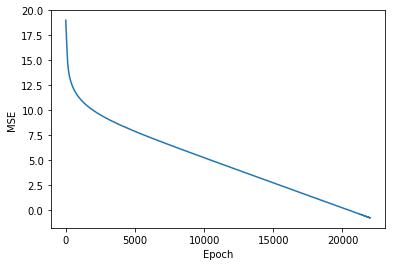


[[0.99993885]
 [0.99994224]]

Post training MSE:  0.027430905
Actual sum:  [2000. 2012. 2024. 2036. 2048. 2060. 2072. 2084. 2096. 2108.]

Predicted sum:  [1999.8811 2011.8804 2023.8796 2035.8789 2047.8782 2059.8774 2071.8767
 2083.876  2095.8755 2107.8745]


In [7]:
# Define the placeholder to feed the value at run time
X = tf.placeholder(dtype=tf.float32, shape =[None , 2])    # Number of samples x Number of features (number of inputs to be added)
Y = tf.placeholder(dtype=tf.float32, shape=[None,])
# define the network
# Here the network contains only one NAC cell (for testing)
y_pred, W = NAC(in_dim=X, out_dim=1)
y_pred = tf.squeeze(y_pred)            # Remove extra dimensions if any
# Mean Square Error (MSE)
loss = tf.reduce_mean( (y_pred - Y) **2)
# training parameters
alpha = 0.05    # learning rate
epochs = 22000
optimize = tf.train.AdamOptimizer(learning_rate=alpha).minimize(loss)
with tf.Session() as sess:
    #init = tf.global_variables_initializer()
    cost_history = []
    sess.run(tf.global_variables_initializer())
    # pre training evaluate
    print("Pre training MSE: ", sess.run (loss, feed_dict={X: x_test, Y:y_test}))
    print()
    for i in range(epochs):
        _, cost = sess.run([optimize, loss ], feed_dict={X:x_train, Y: y_train})
        print("epoch: {}, MSE: {}".format( i,cost) )
        cost_history.append(cost)
    # plot the MSE over each iteration
    plt.plot(np.arange(epochs),np.log(cost_history))  # Plot MSE on log scale
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.show()
    print()
    print(W.eval())
    print()
    # post training loss
    print("Post training MSE: ", sess.run(loss, feed_dict={X: x_test, Y: y_test}))
    print("Actual sum: ", y_test[0:10])
    print()
    print("Predicted sum: ", sess.run(y_pred[0:10], feed_dict={X: x_test, Y: y_test})) 

In [9]:
#The Neural Arithmetic Logic Unit
def NALU(in_dim, out_dim):
    shape = (int(in_dim.shape[-1]), out_dim)
    epsilon = 1e-7
    # NAC
    W_hat = tf.Variable(tf.truncated_normal(shape, stddev=0.02))
    M_hat = tf.Variable(tf.truncated_normal(shape, stddev=0.02))
    G = tf.Variable(tf.truncated_normal(shape, stddev=0.02))
    W = tf.tanh(W_hat) * tf.sigmoid(M_hat)
    # Forward propogation
    a = tf.matmul(in_dim, W)
    # NALU
    m = tf.exp(tf.matmul(tf.log(tf.abs(in_dim) + epsilon), W))
    g = tf.sigmoid(tf.matmul(in_dim, G))
    y = g * a + (1 - g) * m
    return y

In [10]:
# Test the Network by learning the multiplication
# Generate a series of input number X1 and X2 for training
x1 = np.arange(0,10000,5, dtype=np.float32)
x2 = np.arange(5,10005,5, dtype=np.float32)
y_train = x1 * x2
x_train = np.column_stack((x1,x2))
print(x_train.shape)
print(y_train.shape)
# Generate a series of input number X1 and X2 for testing
x1 = np.arange(1000,2000,8, dtype=np.float32)
x2 = np.arange(1000,1500,4, dtype= np.float32)
x_test = np.column_stack((x1,x2))
y_test = x1 * x2
print()
print(x_test.shape)
print(y_test.shape)

(2000, 2)
(2000,)

(125, 2)
(125,)
